In [24]:
import time
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from tqdm import tqdm
import pickle
import random
import numpy as np
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
import gensim.downloader
from torch import FloatTensor as FT

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline

plt.style.use('ggplot')

### Information
- torchtext repo: https://github.com/pytorch/text/tree/main/torchtext
- torchtext documentation: https://pytorch.org/text/stable/index.html

In [5]:
# Where do I want to run my job. You can do "cuda" on linux machines.
DEVICE = "mps" if torch.backends.mps.is_available() else  "cpu"
# The batch size in Adam or SGD.
BATCH_SIZE = 512
# Number of epochs.
NUM_EPOCHS = 10
# Predict from 2 words the inner word for CBOW.
# I.e. I'll have a window like ["a", "b", "c"] of continuous text (each is a word).
# We'll predict each of wc = ["a", "c"] from "b" = wc for Skip-Gram.
# For CBOW, we'll use ["a", "c"] to predict "b" = wo.
WINDOW = 1

# Negative samples.
K = 4

The text8 Wikipedia corpus. 100M characters.

In [6]:
!du -h text8

 95M	text8


In [7]:
f = open('text8', 'r')
text = f.read()
# One big string of size 100M.
print(len(text))

100000000


In [10]:
punc = '!"#$%&()*+,-./:;<=>?@[\\]^_\'{|}~\t\n'

# Can do regular expressions here too.
for c in punc:
    if c in text:
        text.replace(c, ' ')

In [11]:
# A very crude tokenizer you get for free: lower case and also split on spaces.
TOKENIZER = get_tokenizer("basic_english")

In [12]:
words = TOKENIZER(text)
f = Counter(words)

In [13]:
len(words)

17005207

In [14]:
# Do a very crude filter on the text which remoes all words whuch 
text = [word for word in words if f[word] > 5]

In [15]:
text[0:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [16]:
VOCAB = build_vocab_from_iterator([text])

In [17]:
# word -> int hash map.
stoi = VOCAB.get_stoi()
# int -> word hash map.
itos = VOCAB.get_itos() 

In [18]:
stoi['as']

11

In [19]:
# Total number of words.
len(stoi)

63641

In [20]:
f = Counter(text)
# This is the probability that we pick a word in the corpus.
z = {word: f[word] / len(text) for word in f}

In [21]:
threshold = 1e-5
# Probability that word is kept while subsampling.
# This is explained here and sightly differet from the paper: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
p_keep = {word: (np.sqrt(z[word] / 0.001) + 1)*(0.0001 / z[word]) for word in f}

In [26]:
# This is in the integer space.
train_dataset = [word for word in text if random.random() < p_keep[word]]

# Rebuild the vocabulary.
VOCAB = build_vocab_from_iterator([train_dataset])

In [27]:
len(train_dataset)

7847755

In [28]:
# word -> int mapping.
stoi = VOCAB.get_stoi()
# int -> word mapping.
itos = VOCAB.get_itos() 

In [29]:
# The vocabulary size after we do all the filters.
len(VOCAB)

63641

In [30]:
# The probability we draw something for negative sampling.
f = Counter(train_dataset)
p = torch.zeros(len(VOCAB))

# Downsample frequent words and upsample less frequent.
s = sum([np.power(freq, 0.75) for word, freq in f.items()])        

for word in f:
    p[stoi[word]] = np.power(f[word], 0.75) / s

In [31]:
# Map everything to integers.
train_dataset = [stoi[word] for word in text]

In [87]:
# This just gets the (wc, wo) pairs that are positive - they are seen together!
def get_tokenized_dataset(dataset, verbose=False):
    x_list = []
        
    for i, token in enumerate(dataset):
        m = 1
        
        start = max(0,i-m)
        left_tokens = dataset[start:i]
        
        end = min(i+m,len(dataset)-1)
        right_tokens = dataset[i+1:end+1]
                
        if len(left_tokens) == len(right_tokens):
            w_context = left_tokens + right_tokens
            
            wc = token
                        
            x_list.extend(
                [w_context + [wc]]
            )
            
    return x_list

In [88]:
train_x_list = get_tokenized_dataset(train_dataset, verbose=False)

In [89]:
pickle.dump(train_x_list, open('train_x_list.pkl', 'wb'))

In [90]:
train_x_list = pickle.load(open('train_x_list.pkl', 'rb'))

In [101]:
# These are (wc, wo) pairs. All are y = +1 by design.
train_x_list[:10]

[[5233, 11, 3083],
 [3083, 6, 11],
 [11, 190, 6],
 [6, 1, 190],
 [190, 3133, 1],
 [1, 45, 3133],
 [3133, 59, 45],
 [45, 138, 59],
 [59, 134, 138],
 [138, 741, 134]]

In [102]:
# The number of things of BATCH_SIZE = 512.
len(train_x_list) // BATCH_SIZE

32579

### Set up the dataloader.

In [103]:
train_dl = DataLoader(
    TensorDataset(
        torch.tensor(train_x_list).to(DEVICE),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [108]:
for xb in train_dl:
    assert(xb[0].shape == (BATCH_SIZE, 3))
    break

### Words we'll use to asses the quality of the model ...

In [163]:
valid_ids = torch.tensor([
    stoi['money'],
    stoi['lion'],
    stoi['africa'],
    stoi['musician'],
    stoi['dance'],
])

### Get the model.

In [164]:
class CBOWNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOWNegativeSampling, self).__init__()
        self.A = nn.Embedding(vocab_size, embed_dim) # Context vectors - center word.
        self.B = nn.Embedding(vocab_size, embed_dim) # Output vectors - words around the center word.
        self.init_weights()

    def init_weights(self):
        # Is this the best way? Not sure.
        initrange = 0.5
        self.A.weight.data.uniform_(-initrange, initrange)
        self.B.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        # N is the batch size.
        # x is (N, )
        
        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc = x[:, :-1], x[:, -1]
                
        # Each of these is (N, 2, D) since each context has 2 word.
        # We want this to be (N, 1, D)
        a_avg = self.A(w_context).mean(axis=1)
        
        # Each of these is (N, 1, D) since each target has 1 word.
        b = self.B(wc)
                
        # The product between each context and target vector.
        # Each of these is (N, 1, D) since each batch has 1 word.
        # The logits is now (N, 1) since we sum across the final dimension.
        logits = (a_avg * b).sum(axis=-1)
                
        return logits

In [165]:
@torch.no_grad()
def validate_embeddings(
    model,
    valid_ids,
    itos
):
    """ Validation logic """

    # We will use context embeddings to get the most similar words
    # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
    embedding_weights = model.A.weight
        
    normalized_embeddings = embedding_weights.cpu() / np.sqrt(
        np.sum(embedding_weights.cpu().numpy()**2, axis=1, keepdims=True)
    )

    # Get the embeddings corresponding to valid_term_ids
    valid_embeddings = normalized_embeddings[valid_ids, :]

    # Compute the similarity between valid_term_ids (S) and all the embeddings (V).
    # We do S x d (d x V) => S x D and sort by negative similarity.
    top_k = 10 # Top k items will be displayed.
    similarity = np.dot(valid_embeddings.cpu().numpy(), normalized_embeddings.cpu().numpy().T)

    # Invert similarity matrix to negative
    # Ignore the first one because that would be the same word as the probe word
    similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]

    # Print the output.
    for i, word_id in enumerate(valid_ids):
        # j >= 1 here since we don't want to include the word itself.
        similar_word_str = ', '.join([itos[j] for j in similarity_top_k[i, :] if j >= 1])
        print(f"{itos[word_id]}: {similar_word_str}")

    print('\n')

### Set up the model

In [166]:
LR = 10.0
NUM_EPOCHS = 10
EMBED_DIM = 300

In [167]:
model = CBOWNegativeSampling(len(VOCAB), EMBED_DIM).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# The learning rate is lowered every epoch by 1/10.
# Is this a good idea?
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1)

In [ ]:
model

In [ ]:
validate_embeddings(model, valid_ids, itos)

### Train the model

In [168]:
ratios = []

def train(dataloader, model, optimizer, epoch):
    model.train()
    total_acc, total_count, total_loss, total_batches = 0, 0, 0.0, 0.0
    log_interval = 500
    
    for idx, x_batch in tqdm(enumerate(dataloader)):
        
        x_batch = x_batch[0]
                
        batch_size = x_batch.shape[0]
                
        optimizer.zero_grad()
        
        logits = model(x_batch)
                        
        # Get the positive samples loss. Notice we use weights here.
        positive_loss = torch.nn.BCEWithLogitsLoss()(input=logits, target=torch.ones(batch_size).to(DEVICE).float())
        
        # For each batch, get some negative samples.
        # We need a total of batch_size * K samples across a batch.
        # We then reshape this batch.
        # These are effectively the output words.
        negative_samples = torch.multinomial(p, batch_size * K, replacement=True)
        
        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc = x_batch[:, :-1], x_batch[:, -1]
        
        """
        if w_context looks like below (batch_size = 3)
        [
        a,
        b,
        c
        ] and K = 2 we'd like to get:
        
        [
        a,
        a,
        b, 
        b,
        c,
        c
        ]
        
        This will be batch_size * K rows.
        """
        
        # This should be (N * K, 2)
        w_context = torch.concat([
            w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
        ])
        
        wc = negative_samples.unsqueeze(-1)
        
        # Get the negative samples. This shoould be (N * K, 3).
        x_batch_negative = torch.concat([w_context, wc.to(DEVICE)], axis=1)
                
        """
        Note the way we formulated the targets: they are all 0 since these are negative samples.
        We do the BCEWithLogitsLoss by hand basically here.
        Notice we sum across the negative samples, per positive word.
        
        This is literally the equation in the lecture notes.
        """
        
        # (N, K, D) -> (N, D) -> (N)
        negative_loss = model(x_batch_negative).neg().sigmoid().log().reshape(
            batch_size, K
        ).sum(1).mean().neg().to(DEVICE)
        
        loss = (positive_loss + negative_loss).mean()
                
        # Get the gradients via back propagation. 
        loss.backward()
                        
        # Clip the gradients? Generally a good idea.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Used for optimization. This should be roughly 0.001, on average.
        # You can use this to see if your learning rate is right - you can also plot the loss performance.
        with torch.no_grad():
            r = [
                (LR * p.grad.std() / p.data.std()).log10().item() for _, p in model.named_parameters()
            ]
            ratios.append(r)  
        
        # Do an optimization step. Update the parameters A and B.
        optimizer.step()
        total_loss += loss.item()
        total_batches += 1
                
        if idx % log_interval == 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| loss {:8.3f} ".format(
                    epoch,
                    idx,
                    len(dataloader),
                    total_loss / total_batches
                )
            )
            validate_embeddings(model, valid_ids, itos)
            total_loss, total_batches = 0.0, 0.0

### Some results from the run look like below:

Results?

In [169]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    
    train(train_dl, model, optimizer, epoch)
    # We have a learning rate scheduler here.
    # Basically, given the state of the optimizer, this lowers the learning rate in a smart way.
    scheduler.step()

0it [00:00, ?it/s]/var/folders/x8/2_vxppc52znb82mg86nv4y000000gn/T/ipykernel_9301/3264625997.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
1it [00:00,  2.46it/s]

| epoch   1 |     0/32580 batches | loss    4.027 
money: coyotes, furtado, flanking, managed, infogrames, startrek, reyna, damian, larry, pseudonyms
lion: aksai, dumpster, interpolation, mixture, rale, sabor, aphasia, prokaryotes, gametophyte, urology
africa: virginian, wendish, caryophyllales, electricity, warlike, swamp, bombay, catechisms, surrealistic, jacques
musician: lothal, exponent, orsay, awami, screwed, aedui, vassalage, smalltalk, padova, ivo
dance: akhmatova, monty, chunk, bofors, desqview, nephew, emitter, quaternary, recombination, strasser




501it [01:11,  6.33it/s]

| epoch   1 |   500/32580 batches | loss    3.719 
money: coyotes, furtado, flanking, managed, infogrames, startrek, reyna, damian, larry, speedway
lion: aksai, dumpster, interpolation, mixture, rale, sabor, aphasia, prokaryotes, gametophyte, urology
africa: virginian, wendish, caryophyllales, bombay, jacques, electricity, warlike, inactivation, surrealistic, catechisms
musician: lothal, exponent, orsay, awami, screwed, vassalage, aedui, smalltalk, padova, gatt
dance: akhmatova, monty, bofors, chunk, desqview, nephew, emitter, quaternary, recombination, strasser




1001it [02:21,  6.29it/s]

| epoch   1 |  1000/32580 batches | loss    3.363 
money: coyotes, furtado, flanking, managed, reyna, infogrames, startrek, damian, speedway, airfields
lion: aksai, dumpster, mixture, interpolation, rale, sabor, gametophyte, prokaryotes, aphasia, urology
africa: virginian, bombay, wendish, caryophyllales, jacques, electricity, warlike, inactivation, surrealistic, catechisms
musician: lothal, exponent, orsay, awami, screwed, vassalage, smalltalk, aedui, padova, gatt
dance: akhmatova, monty, chunk, bofors, desqview, nephew, emitter, quaternary, recombination, strasser




1501it [03:33,  6.20it/s]

| epoch   1 |  1500/32580 batches | loss    2.968 
money: coyotes, furtado, flanking, managed, reyna, infogrames, startrek, damian, speedway, larry
lion: aksai, dumpster, mixture, interpolation, sabor, rale, gametophyte, prokaryotes, aphasia, krishnamurti
africa: virginian, bombay, jacques, caryophyllales, wendish, electricity, inactivation, warlike, surrealistic, beckwith
musician: lothal, orsay, exponent, awami, vassalage, smalltalk, vestibule, felicity, coherentism, padova
dance: akhmatova, chunk, monty, bofors, desqview, emitter, nephew, quaternary, recombination, strasser




2001it [04:43,  6.10it/s]

| epoch   1 |  2000/32580 batches | loss    2.679 
money: coyotes, furtado, flanking, managed, infogrames, reyna, damian, startrek, speedway, airfields
lion: aksai, dumpster, mixture, interpolation, sabor, gametophyte, rale, prokaryotes, aphasia, krishnamurti
africa: bombay, jacques, virginian, caryophyllales, electricity, wendish, warlike, inactivation, late, through
musician: lothal, orsay, exponent, awami, coherentism, vassalage, vestibule, felicity, antonia, hughes
dance: akhmatova, monty, chunk, bofors, emitter, nephew, desqview, quaternary, recombination, strasser




2501it [05:55,  6.19it/s]

| epoch   1 |  2500/32580 batches | loss    2.526 
money: coyotes, flanking, managed, furtado, damian, infogrames, larry, airfields, reyna, startrek
lion: aksai, dumpster, mixture, sabor, interpolation, gametophyte, prokaryotes, krishnamurti, rale, aphasia
africa: also, an, through, bombay, jacques, which, virginian, time, people, john
musician: lothal, orsay, exponent, awami, coherentism, vestibule, vassalage, felicity, hughes, antonia
dance: akhmatova, monty, bofors, chunk, emitter, nephew, desqview, quaternary, recombination, rearwards




3001it [07:05,  6.32it/s]

| epoch   1 |  3000/32580 batches | loss    2.439 
money: coyotes, flanking, managed, furtado, damian, their, airfields, larry, infogrames, speedway
lion: aksai, dumpster, mixture, sabor, interpolation, gametophyte, prokaryotes, krishnamurti, rale, spun
africa: also, which, one, used, people, an, two, through, time, it
musician: lothal, orsay, exponent, vestibule, awami, coherentism, vassalage, hughes, felicity, angled
dance: akhmatova, monty, bofors, chunk, nephew, emitter, quaternary, desqview, recombination, westenra




3501it [08:16,  6.28it/s]

| epoch   1 |  3500/32580 batches | loss    2.342 
money: coyotes, managed, flanking, furtado, damian, their, larry, speedway, airfields, infogrames
lion: aksai, dumpster, mixture, sabor, prokaryotes, interpolation, gametophyte, krishnamurti, spun, disciplining
africa: also, an, people, used, one, which, time, seven, that, john
musician: lothal, orsay, vestibule, exponent, awami, coherentism, vassalage, hughes, rest, make
dance: akhmatova, monty, bofors, chunk, nephew, emitter, desqview, quaternary, range, recombination




4001it [09:26,  6.23it/s]

| epoch   1 |  4000/32580 batches | loss    2.305 
money: coyotes, their, managed, flanking, damian, furtado, larry, airfields, speedway, an
lion: aksai, dumpster, mixture, sabor, gametophyte, prokaryotes, interpolation, krishnamurti, aphasia, disciplining
africa: also, used, time, which, an, people, one, seven, five, john
musician: lothal, orsay, vestibule, exponent, make, hughes, like, rest, coherentism, awami
dance: akhmatova, bofors, monty, chunk, nephew, emitter, quaternary, range, desqview, recombination




4501it [10:36,  6.26it/s]

| epoch   1 |  4500/32580 batches | loss    2.220 
money: their, coyotes, managed, an, flanking, sea, damian, larry, other, furtado
lion: aksai, dumpster, mixture, sabor, gametophyte, interpolation, prokaryotes, spun, krishnamurti, aphasia
africa: also, which, time, used, an, people, one, through, five, two
musician: lothal, orsay, like, vestibule, make, war, hughes, exponent, rest, removal
dance: akhmatova, range, bofors, chunk, nephew, emitter, names, monty, strasser, rearwards




5001it [11:46,  6.26it/s]

| epoch   1 |  5000/32580 batches | loss    2.113 
money: their, an, managed, sea, only, coyotes, other, many, flanking, known
lion: aksai, dumpster, mixture, sabor, gametophyte, interpolation, spun, prokaryotes, disciplining, krishnamurti
africa: also, used, time, which, people, three, two, seven, four, five
musician: lothal, orsay, war, country, make, rest, vestibule, group, like, hughes
dance: range, akhmatova, names, nephew, bofors, emitter, chunk, programming, rearwards, among




5501it [12:57,  6.31it/s]

| epoch   1 |  5500/32580 batches | loss    2.080 
money: their, an, other, sea, only, many, managed, known, there, it
lion: aksai, dumpster, mixture, gametophyte, sabor, spun, interpolation, prokaryotes, disciplining, discussed
africa: also, used, time, people, which, five, three, four, seven, one
musician: war, lothal, like, group, north, make, country, people, orsay, south
dance: range, names, nephew, akhmatova, among, bofors, others, emitter, hundreds, chunk




6001it [14:07,  6.28it/s]

| epoch   1 |  6000/32580 batches | loss    2.053 
money: their, only, an, many, there, other, known, it, sea, managed
lion: aksai, dumpster, mixture, gametophyte, sabor, prokaryotes, spun, interpolation, disciplining, discussed
africa: also, used, time, people, which, four, five, two, three, one
musician: war, group, like, lothal, make, people, north, country, south, orsay
dance: range, names, others, among, much, hundreds, nephew, other, bofors, akhmatova




6501it [15:18,  6.16it/s]

| epoch   1 |  6500/32580 batches | loss    1.983 
money: their, many, only, there, known, other, all, which, it, usually
lion: aksai, mixture, dumpster, gametophyte, sabor, prokaryotes, spun, discussed, disciplining, krishnamurti
africa: time, used, also, people, four, which, two, often, three, through
musician: war, north, group, like, make, south, country, people, lothal, league
dance: range, among, others, names, hundreds, much, nephew, other, british, bofors




7001it [16:29,  6.22it/s]

| epoch   1 |  7000/32580 batches | loss    2.010 
money: there, their, only, many, known, it, all, which, usually, most
lion: aksai, dumpster, mixture, spun, gametophyte, prokaryotes, discussed, disciplining, sabor, krishnamurti
africa: time, people, used, also, four, seven, often, five, three, one
musician: north, group, war, like, country, south, make, people, lothal, rest
dance: range, among, others, much, names, other, hundreds, british, line, career




7501it [17:41,  6.21it/s]

| epoch   1 |  7500/32580 batches | loss    1.959 
money: only, there, known, their, many, it, then, usually, which, all
lion: aksai, mixture, dumpster, spun, gametophyte, discussed, prokaryotes, disciplining, met, sabor
africa: people, four, time, used, often, seven, one, also, five, three
musician: group, war, north, like, country, south, make, rest, people, eastern
dance: range, others, among, other, names, much, hundreds, line, british, career




8001it [18:53,  6.15it/s]

| epoch   1 |  8000/32580 batches | loss    1.891 
money: there, only, known, it, many, usually, use, all, then, their
lion: aksai, mixture, dumpster, spun, discussed, met, gametophyte, prokaryotes, disciplining, sabor
africa: time, people, four, used, seven, three, often, nine, also, one
musician: group, war, north, like, south, country, culture, rest, people, eastern
dance: range, among, others, other, names, much, british, hundreds, same, line




8501it [20:05,  6.16it/s]

| epoch   1 |  8500/32580 batches | loss    1.896 
money: only, there, known, use, all, then, usually, it, many, well
lion: aksai, mixture, dumpster, spun, discussed, gametophyte, met, prokaryotes, disciplining, sabor
africa: time, people, used, four, seven, nine, three, often, five, which
musician: group, north, war, south, like, country, eastern, culture, rest, based
dance: range, other, others, among, names, much, british, hundreds, same, terms




9001it [21:17,  6.19it/s]

| epoch   1 |  9000/32580 batches | loss    1.884 
money: only, there, use, all, known, then, usually, well, god, death
lion: aksai, mixture, dumpster, discussed, spun, met, gametophyte, prokaryotes, disciplining, sabor
africa: time, people, four, seven, used, nine, often, three, five, history
musician: group, north, war, south, culture, country, eastern, like, rest, based
dance: range, other, others, names, among, much, hundreds, british, terms, latter




9501it [22:28,  6.29it/s]

| epoch   1 |  9500/32580 batches | loss    1.870 
money: only, there, known, use, usually, all, well, death, god, people
lion: aksai, mixture, dumpster, discussed, met, spun, gametophyte, disciplining, prokaryotes, sabor
africa: time, people, used, four, seven, nine, five, three, which, use
musician: group, north, war, south, culture, eastern, country, rest, led, like
dance: range, other, others, names, terms, among, hundreds, british, space, much




10002it [23:39,  6.49it/s]

| epoch   1 | 10000/32580 batches | loss    1.866 
money: only, use, known, there, usually, death, then, well, god, all
lion: aksai, mixture, dumpster, met, discussed, gametophyte, spun, disciplining, prokaryotes, sabor
africa: four, seven, time, used, people, five, nine, three, history, university
musician: group, north, war, culture, eastern, south, country, rest, led, league
dance: range, others, other, names, terms, british, space, among, hundreds, version




10501it [24:49,  6.23it/s]

| epoch   1 | 10500/32580 batches | loss    1.858 
money: known, use, death, usually, only, god, support, there, well, all
lion: aksai, mixture, met, dumpster, discussed, spun, gametophyte, disciplining, prokaryotes, czech
africa: four, seven, time, nine, five, used, history, people, university, three
musician: group, north, war, eastern, culture, south, rest, country, led, like
dance: range, others, other, names, terms, british, space, hundreds, version, among




11001it [26:01,  6.21it/s]

| epoch   1 | 11000/32580 batches | loss    1.840 
money: known, death, use, usually, god, then, well, all, people, support
lion: mixture, aksai, met, dumpster, discussed, spun, gametophyte, disciplining, prokaryotes, sabor
africa: four, seven, used, nine, history, five, time, university, north, people
musician: group, north, eastern, war, culture, south, rest, country, led, like
dance: range, others, names, other, terms, space, british, end, among, hundreds




11501it [27:12,  6.28it/s]

| epoch   1 | 11500/32580 batches | loss    1.776 
money: use, death, known, god, support, usually, people, well, list, then
lion: aksai, mixture, met, discussed, dumpster, spun, gametophyte, prokaryotes, disciplining, czech
africa: four, seven, nine, five, used, america, time, history, three, north
musician: north, group, eastern, culture, war, rest, south, country, league, led
dance: range, others, names, other, terms, space, end, hundreds, british, version




12001it [28:23,  6.18it/s]

| epoch   1 | 12000/32580 batches | loss    1.767 
money: use, death, god, known, support, well, list, only, people, then
lion: mixture, aksai, met, discussed, dumpster, spun, prokaryotes, disciplining, gametophyte, czech
africa: four, seven, america, history, nine, used, five, time, north, three
musician: north, culture, eastern, group, rest, war, south, led, country, league
dance: range, others, other, end, names, british, terms, list, line, among




12501it [29:33,  6.24it/s]

| epoch   1 | 12500/32580 batches | loss    1.722 
money: use, death, god, support, known, well, list, people, work, example
lion: mixture, aksai, met, discussed, dumpster, spun, prokaryotes, disciplining, gametophyte, sabor
africa: seven, america, four, five, nine, history, used, time, north, three
musician: group, north, culture, war, eastern, country, rest, south, led, people
dance: range, others, other, names, end, terms, line, list, british, version




13001it [30:44,  6.16it/s]

| epoch   1 | 13000/32580 batches | loss    1.751 
money: use, death, god, support, known, usually, list, well, work, then
lion: mixture, aksai, met, discussed, dumpster, spun, disciplining, prokaryotes, gametophyte, included
africa: america, seven, five, four, north, history, nine, three, area, end
musician: north, group, war, culture, eastern, south, country, rest, league, led
dance: range, others, other, names, end, terms, line, list, space, united




13501it [31:55,  6.13it/s]

| epoch   1 | 13500/32580 batches | loss    1.713 
money: use, death, support, god, known, list, usually, work, example, well
lion: mixture, aksai, met, discussed, dumpster, spun, prokaryotes, abuse, disciplining, gametophyte
africa: america, seven, five, north, history, end, nine, area, eight, late
musician: north, group, war, culture, south, eastern, country, led, people, league
dance: range, other, others, end, terms, list, names, line, united, last




14001it [33:06,  6.20it/s]

| epoch   1 | 14000/32580 batches | loss    1.725 
money: use, support, death, god, known, work, list, well, then, people
lion: mixture, aksai, met, discussed, dumpster, abuse, spun, included, disciplining, prokaryotes
africa: america, seven, five, north, history, nine, end, part, late, eight
musician: north, group, war, culture, eastern, country, south, led, people, league
dance: range, other, others, list, united, end, terms, british, last, line




14501it [34:18,  6.09it/s]

| epoch   1 | 14500/32580 batches | loss    1.644 
money: support, use, death, work, god, list, people, example, known, usually
lion: mixture, aksai, met, discussed, dumpster, abuse, included, spun, disciplining, czech
africa: america, seven, north, history, five, end, nine, late, part, eight
musician: north, group, eastern, south, culture, war, country, led, people, rest
dance: range, other, united, end, others, list, terms, last, same, use




15001it [35:29,  6.23it/s]

| epoch   1 | 15000/32580 batches | loss    1.684 
money: support, use, death, god, list, work, people, example, known, name
lion: mixture, aksai, met, discussed, abuse, dumpster, included, introduced, spun, czech
africa: america, five, seven, north, end, history, nine, part, late, four
musician: north, group, war, south, eastern, culture, country, led, rest, league
dance: range, united, other, others, list, end, terms, british, same, line




15501it [36:40,  6.09it/s]

| epoch   1 | 15500/32580 batches | loss    1.682 
money: support, use, death, god, work, list, example, people, known, name
lion: mixture, met, aksai, discussed, included, abuse, saints, introduced, dumpster, czech
africa: america, seven, end, north, history, five, nine, part, late, england
musician: north, group, war, south, culture, eastern, country, led, rest, league
dance: range, united, list, terms, others, other, end, british, same, those




16001it [37:51,  6.22it/s]

| epoch   1 | 16000/32580 batches | loss    1.650 
money: support, use, death, work, god, name, example, list, well, known
lion: mixture, met, aksai, discussed, included, abuse, saints, quantum, introduced, dumpster
africa: america, end, north, history, seven, five, england, late, eight, nine
musician: north, group, culture, south, eastern, war, country, led, rest, league
dance: range, list, united, terms, other, end, others, same, british, those




16501it [39:02,  6.16it/s]

| epoch   1 | 16500/32580 batches | loss    1.629 
money: support, use, death, work, god, name, example, well, list, known
lion: mixture, met, aksai, discussed, included, introduced, saints, abuse, quantum, organisation
africa: america, end, north, history, seven, five, nine, late, england, part
musician: north, group, south, culture, war, eastern, country, rest, led, england
dance: range, list, end, united, terms, others, other, british, same, those




17001it [40:13,  6.13it/s]

| epoch   1 | 17000/32580 batches | loss    1.587 
money: support, use, death, work, god, name, example, production, well, known
lion: mixture, met, discussed, aksai, included, saints, introduced, abuse, quantum, czech
africa: america, end, north, seven, history, five, england, late, part, u
musician: north, group, south, war, culture, country, eastern, england, led, europe
dance: range, list, end, terms, united, others, other, same, last, those




17501it [41:24,  6.06it/s]

| epoch   1 | 17500/32580 batches | loss    1.685 
money: support, use, death, work, god, name, example, production, people, usually
lion: mixture, met, discussed, aksai, included, saints, introduced, abuse, czech, organisation
africa: america, end, history, north, seven, england, five, part, nine, late
musician: north, group, south, war, culture, country, england, eastern, led, actress
dance: range, terms, list, end, united, others, same, other, last, country




18001it [42:35,  6.26it/s]

| epoch   1 | 18000/32580 batches | loss    1.623 
money: support, use, work, death, name, god, example, view, production, well
lion: mixture, met, discussed, included, aksai, introduced, saints, abuse, czech, organisation
africa: america, end, north, history, five, u, seven, part, late, nine
musician: north, group, south, culture, country, england, war, eastern, actress, europe
dance: range, terms, list, united, other, end, others, same, last, country




18501it [43:47,  6.15it/s]

| epoch   1 | 18500/32580 batches | loss    1.524 
money: support, use, work, death, god, example, name, view, production, list
lion: mixture, met, discussed, introduced, aksai, saints, included, abuse, czech, question
africa: america, end, north, history, nine, u, part, five, europe, late
musician: north, group, culture, south, england, eastern, war, country, actress, europe
dance: range, terms, list, united, end, other, others, same, country, those




19001it [45:00,  6.00it/s]

| epoch   1 | 19000/32580 batches | loss    1.608 
money: support, use, work, death, example, view, name, production, god, list
lion: mixture, met, discussed, introduced, included, saints, aksai, abuse, question, czech
africa: america, end, north, history, seven, five, nine, europe, part, u
musician: north, group, culture, south, england, eastern, war, actress, country, four
dance: range, terms, list, united, other, end, others, same, last, country




19501it [46:13,  6.11it/s]

| epoch   1 | 19500/32580 batches | loss    1.618 
money: support, use, work, death, example, production, view, name, list, nine
lion: mixture, met, discussed, introduced, included, saints, abuse, aksai, question, quantum
africa: america, end, north, history, nine, europe, late, china, eight, seven
musician: north, culture, south, england, war, eastern, group, four, actress, country
dance: range, terms, list, united, other, end, others, same, country, nine




20001it [47:24,  6.24it/s]

| epoch   1 | 20000/32580 batches | loss    1.610 
money: support, use, work, death, view, example, production, name, list, nine
lion: met, mixture, discussed, introduced, included, abuse, saints, aksai, question, quantum
africa: america, end, north, nine, seven, eight, late, europe, china, three
musician: north, culture, south, england, four, eastern, eight, actress, war, group
dance: range, terms, united, list, other, end, country, others, use, york




20501it [48:36,  6.02it/s]

| epoch   1 | 20500/32580 batches | loss    1.524 
money: support, use, work, view, example, death, name, production, nine, list
lion: met, mixture, discussed, introduced, included, abuse, saints, question, aksai, quantum
africa: america, end, north, europe, late, nine, china, seven, england, eight
musician: north, culture, south, england, eastern, actress, eight, rest, four, group
dance: range, terms, list, other, united, end, use, country, others, york




21001it [49:48,  6.01it/s]

| epoch   1 | 21000/32580 batches | loss    1.564 
money: support, work, use, view, death, god, example, name, list, production
lion: met, mixture, discussed, introduced, included, abuse, saints, question, quantum, organisation
africa: america, end, north, europe, late, england, china, nine, eight, france
musician: north, culture, england, eastern, south, rest, actress, war, group, eight
dance: terms, range, list, other, united, end, country, use, others, york




21501it [51:01,  6.30it/s]

| epoch   1 | 21500/32580 batches | loss    1.531 
money: support, work, use, view, death, god, example, production, list, name
lion: met, mixture, discussed, introduced, included, abuse, saints, question, pope, quantum
africa: america, end, north, europe, england, china, nine, late, france, part
musician: north, england, group, culture, eastern, rest, south, eight, actress, fact
dance: terms, range, list, united, other, end, country, use, nine, york




22001it [52:10,  6.22it/s]

| epoch   1 | 22000/32580 batches | loss    1.564 
money: support, work, use, death, view, god, example, production, list, nine
lion: met, mixture, discussed, introduced, included, abuse, saints, question, pope, show
africa: america, end, north, europe, england, china, nine, late, france, part
musician: north, england, rest, south, eight, group, culture, eastern, actress, fact
dance: terms, range, list, united, other, country, end, nine, york, use




22502it [53:21,  6.56it/s]

| epoch   1 | 22500/32580 batches | loss    1.579 
money: support, work, use, death, view, example, god, production, name, usually
lion: met, mixture, discussed, introduced, included, abuse, saints, pope, question, show
africa: america, end, europe, north, england, china, late, nine, france, history
musician: north, england, group, rest, south, culture, eastern, eight, actress, fact
dance: terms, range, list, united, other, country, end, york, same, nine




23002it [54:31,  6.55it/s]

| epoch   1 | 23000/32580 batches | loss    1.490 
money: support, work, use, view, god, death, example, production, name, nine
lion: met, mixture, discussed, included, introduced, abuse, saints, question, pope, organisation
africa: america, end, europe, north, england, china, nine, late, india, france
musician: north, england, rest, eastern, south, actress, eight, culture, group, fact
dance: range, terms, list, other, united, country, end, york, same, nine




23501it [55:41,  6.31it/s]

| epoch   1 | 23500/32580 batches | loss    1.517 
money: support, work, view, use, death, god, example, production, nine, name
lion: met, mixture, discussed, abuse, introduced, included, saints, question, pope, organisation
africa: america, end, europe, north, england, nine, seven, five, china, late
musician: north, rest, england, eight, four, group, eastern, actress, culture, south
dance: range, terms, united, other, list, country, end, york, irish, nine




24001it [56:52,  6.14it/s]

| epoch   1 | 24000/32580 batches | loss    1.525 
money: support, work, use, death, god, example, view, production, name, nine
lion: met, mixture, abuse, discussed, introduced, included, saints, question, pope, society
africa: america, end, north, europe, nine, england, china, india, late, u
musician: north, england, rest, eight, group, eastern, actress, south, fact, culture
dance: terms, range, other, list, united, end, country, york, irish, u




24502it [58:04,  6.60it/s]

| epoch   1 | 24500/32580 batches | loss    1.374 
money: support, work, example, death, use, view, god, production, name, end
lion: met, mixture, abuse, discussed, included, introduced, saints, question, organisation, society
africa: america, end, europe, north, nine, england, china, india, late, eight
musician: actress, north, actor, england, rest, fact, eight, four, group, south
dance: range, terms, other, united, list, end, irish, country, u, york




25001it [59:16,  6.09it/s]

| epoch   1 | 25000/32580 batches | loss    1.307 
money: support, work, death, example, use, god, view, production, nine, end
lion: met, mixture, abuse, introduced, included, discussed, saints, question, organisation, society
africa: america, end, europe, north, nine, england, china, india, late, france
musician: actress, actor, four, north, singer, one, england, writer, u, three
dance: range, terms, other, united, list, country, end, irish, actor, york




25502it [1:00:28,  6.52it/s]

| epoch   1 | 25500/32580 batches | loss    1.413 
money: support, work, death, example, nine, god, use, production, view, end
lion: met, mixture, abuse, introduced, included, discussed, saints, society, question, organisation
africa: america, end, north, europe, nine, india, china, england, eight, france
musician: actress, actor, singer, four, writer, nine, composer, north, six, england
dance: range, terms, other, united, list, country, actor, end, u, york




26002it [1:01:38,  6.65it/s]

| epoch   1 | 26000/32580 batches | loss    1.470 
money: support, work, death, example, use, production, god, view, nine, end
lion: met, mixture, abuse, introduced, included, saints, discussed, society, question, pope
africa: america, end, north, europe, nine, india, china, england, france, eight
musician: actress, actor, singer, writer, nine, composer, seven, four, england, north
dance: range, terms, united, other, list, country, actor, end, u, york




26502it [1:02:48,  6.60it/s]

| epoch   1 | 26500/32580 batches | loss    1.471 
money: support, work, death, example, use, nine, god, end, view, production
lion: met, mixture, abuse, introduced, included, discussed, saints, question, society, pope
africa: america, end, north, nine, europe, india, china, england, france, united
musician: actress, actor, singer, writer, nine, composer, north, four, england, six
dance: range, terms, united, list, other, country, end, actor, york, version




27002it [1:03:58,  6.67it/s]

| epoch   1 | 27000/32580 batches | loss    1.530 
money: support, work, death, use, example, god, production, end, view, nine
lion: met, mixture, abuse, introduced, included, discussed, saints, question, society, pope
africa: america, end, north, europe, india, nine, china, england, france, result
musician: actress, actor, singer, four, writer, composer, nine, north, eight, england
dance: terms, range, united, other, list, country, end, york, zero, actor




27501it [1:05:08,  6.36it/s]

| epoch   1 | 27500/32580 batches | loss    1.453 
money: support, work, god, death, example, use, production, end, view, much
lion: met, mixture, introduced, abuse, included, discussed, question, saints, society, pope
africa: america, end, north, europe, india, china, nine, england, result, united
musician: actress, actor, singer, writer, four, composer, north, nine, eight, england
dance: terms, range, united, other, list, country, zero, end, actor, york




28001it [1:06:18,  6.35it/s]

| epoch   1 | 28000/32580 batches | loss    1.457 
money: support, work, use, god, death, example, production, view, end, nine
lion: met, mixture, introduced, abuse, included, discussed, question, saints, pope, society
africa: america, end, north, europe, nine, india, china, england, result, united
musician: actress, actor, singer, nine, writer, composer, north, rest, eight, four
dance: terms, united, range, other, list, country, actor, end, york, nine




28502it [1:07:28,  6.58it/s]

| epoch   1 | 28500/32580 batches | loss    1.510 
money: support, work, god, death, use, example, production, view, end, nine
lion: met, mixture, introduced, abuse, discussed, included, saints, question, pope, society
africa: america, end, europe, north, nine, china, india, england, result, united
musician: actress, actor, singer, nine, composer, writer, four, north, deaths, rest
dance: terms, range, united, other, country, list, york, nine, end, actor




29001it [1:08:38,  6.41it/s]

| epoch   1 | 29000/32580 batches | loss    1.528 
money: support, work, god, death, use, production, view, example, end, seen
lion: met, mixture, introduced, abuse, discussed, included, saints, question, pope, society
africa: america, end, europe, north, china, india, nine, england, result, france
musician: actress, actor, singer, nine, composer, writer, deaths, north, four, rest
dance: terms, range, united, other, country, york, end, list, version, origin




29502it [1:09:47,  6.63it/s]

| epoch   1 | 29500/32580 batches | loss    1.481 
money: support, work, god, death, use, view, production, example, end, nine
lion: met, mixture, introduced, abuse, saints, discussed, included, pope, society, question
africa: america, end, europe, china, north, india, nine, england, result, united
musician: actress, actor, singer, nine, composer, deaths, writer, north, rest, england
dance: terms, other, range, united, country, version, york, end, list, origin




30002it [1:10:57,  6.57it/s]

| epoch   1 | 30000/32580 batches | loss    1.303 
money: support, work, death, use, god, view, production, nine, end, example
lion: met, mixture, introduced, abuse, discussed, saints, included, pope, question, organisation
africa: america, end, europe, north, china, india, nine, england, france, asia
musician: actress, actor, singer, nine, composer, writer, deaths, north, six, seven
dance: terms, other, range, united, country, list, end, version, york, nine




30501it [1:12:06,  6.32it/s]

| epoch   1 | 30500/32580 batches | loss    1.418 
money: support, work, death, use, view, god, end, example, production, seen
lion: met, mixture, introduced, abuse, discussed, saints, question, included, pope, organisation
africa: america, end, china, europe, india, north, nine, england, france, asia
musician: actress, actor, singer, composer, writer, nine, deaths, four, six, seven
dance: terms, other, united, country, range, list, end, version, york, actor




31002it [1:13:16,  6.58it/s]

| epoch   1 | 31000/32580 batches | loss    1.447 
money: support, use, work, death, god, view, example, end, production, usually
lion: met, mixture, introduced, abuse, saints, discussed, included, question, pope, organisation
africa: america, end, china, europe, india, north, england, nine, france, asia
musician: actress, actor, singer, writer, composer, nine, deaths, seven, author, four
dance: terms, united, other, range, country, list, version, end, actor, york




31501it [1:14:25,  6.34it/s]

| epoch   1 | 31500/32580 batches | loss    1.435 
money: support, use, work, death, view, god, example, usually, performed, production
lion: met, mixture, introduced, abuse, discussed, saints, included, pope, question, organisation
africa: america, end, china, india, europe, north, england, france, nine, asia
musician: actress, actor, singer, composer, writer, deaths, nine, seven, author, november
dance: terms, other, range, country, united, list, version, origin, september, same




32002it [1:15:35,  6.61it/s]

| epoch   1 | 32000/32580 batches | loss    1.422 
money: support, use, work, death, example, god, view, performed, them, well
lion: met, mixture, introduced, abuse, discussed, saints, organisation, question, pope, included
africa: america, india, end, china, europe, north, england, asia, nine, france
musician: actress, actor, singer, writer, composer, four, deaths, nine, six, author
dance: terms, country, other, range, united, list, origin, version, september, end




32502it [1:16:45,  6.60it/s]

| epoch   1 | 32500/32580 batches | loss    1.491 
money: support, use, work, death, example, view, usually, god, performed, end
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, europe, china, end, north, england, asia, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, zero, november
dance: terms, country, other, united, range, list, origin, version, end, september




32580it [1:16:55,  7.06it/s]
1it [00:00,  4.52it/s]

| epoch   2 |     0/32580 batches | loss    1.498 
money: support, use, work, death, example, view, usually, god, performed, them
lion: met, mixture, introduced, abuse, saints, discussed, question, organisation, pope, included
africa: america, india, china, europe, end, north, england, asia, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, zero, november
dance: terms, other, country, music, list, origin, range, version, actor, same




501it [01:10,  6.32it/s]

| epoch   2 |   500/32580 batches | loss    1.481 
money: support, use, work, death, example, view, usually, performed, god, them
lion: met, mixture, introduced, abuse, saints, discussed, question, organisation, pope, included
africa: america, india, china, europe, end, north, england, asia, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, november, zero
dance: terms, other, country, music, list, origin, range, version, same, actor




1001it [02:19,  6.37it/s]

| epoch   2 |  1000/32580 batches | loss    1.477 
money: support, use, work, death, example, view, usually, performed, god, them
lion: met, mixture, introduced, abuse, saints, discussed, question, organisation, pope, included
africa: america, india, china, europe, end, north, england, asia, france, nine
musician: actress, actor, singer, composer, writer, nine, deaths, author, november, zero
dance: terms, other, country, music, origin, list, range, same, version, actor




1501it [03:29,  6.39it/s]

| epoch   2 |  1500/32580 batches | loss    1.413 
money: support, use, work, death, example, view, usually, performed, god, them
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, england, asia, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, november, zero
dance: terms, other, country, music, origin, list, range, same, version, actor




2001it [04:39,  6.24it/s]

| epoch   2 |  2000/32580 batches | loss    1.412 
money: support, use, work, death, example, usually, view, performed, god, them
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, england, asia, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: terms, other, country, music, origin, list, same, range, actor, version




2502it [05:49,  6.63it/s]

| epoch   2 |  2500/32580 batches | loss    1.416 
money: support, use, work, death, example, usually, view, performed, god, them
lion: met, mixture, introduced, abuse, saints, discussed, question, organisation, pope, included
africa: america, india, china, europe, end, north, england, asia, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, zero
dance: terms, other, country, music, list, origin, actor, same, range, version




3001it [06:58,  6.29it/s]

| epoch   2 |  3000/32580 batches | loss    1.430 
money: support, use, work, death, example, usually, view, performed, them, god
lion: met, mixture, introduced, abuse, saints, discussed, question, organisation, pope, included
africa: america, india, china, europe, end, north, england, asia, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: terms, country, other, music, origin, list, actor, same, range, september




3501it [08:08,  6.31it/s]

| epoch   2 |  3500/32580 batches | loss    1.451 
money: support, use, work, death, example, usually, view, performed, them, god
lion: met, mixture, introduced, abuse, saints, discussed, question, organisation, pope, included
africa: america, india, china, europe, end, north, england, asia, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: terms, country, other, music, origin, list, actor, range, september, same




4002it [09:18,  6.58it/s]

| epoch   2 |  4000/32580 batches | loss    1.461 
money: support, use, work, death, example, usually, performed, view, god, fact
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, england, asia, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: terms, country, other, origin, music, list, actor, range, september, version




4501it [10:27,  6.34it/s]

| epoch   2 |  4500/32580 batches | loss    1.443 
money: support, use, work, death, example, usually, performed, view, them, god
lion: met, mixture, introduced, abuse, saints, discussed, question, organisation, pope, included
africa: america, india, china, europe, end, north, england, asia, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: terms, country, other, origin, music, list, actor, traditional, september, range




5001it [11:37,  6.34it/s]

| epoch   2 |  5000/32580 batches | loss    1.402 
money: support, use, work, death, example, usually, performed, view, them, fact
lion: met, mixture, introduced, abuse, saints, discussed, question, organisation, pope, included
africa: america, india, china, europe, end, north, england, asia, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, zero
dance: terms, country, other, music, origin, list, actor, traditional, september, same




5502it [12:47,  6.71it/s]

| epoch   2 |  5500/32580 batches | loss    1.441 
money: support, use, work, death, example, usually, view, performed, fact, god
lion: met, mixture, introduced, abuse, saints, discussed, question, organisation, pope, included
africa: america, india, china, europe, end, north, england, asia, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, zero
dance: terms, country, other, music, origin, list, actor, traditional, september, version




6002it [1:51:46,  6.66it/s] 

| epoch   2 |  6000/32580 batches | loss    1.440 
money: support, use, work, death, example, usually, performed, view, god, them
lion: met, mixture, introduced, abuse, saints, discussed, question, organisation, pope, included
africa: america, india, china, europe, end, north, england, asia, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, zero
dance: terms, country, other, music, origin, list, actor, traditional, version, september




6501it [1:58:35,  6.17it/s]

| epoch   2 |  6500/32580 batches | loss    1.441 
money: support, use, work, death, example, usually, performed, view, god, fact
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, england, asia, nine, france
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: terms, country, other, music, origin, list, actor, traditional, september, version




7002it [1:59:44,  6.60it/s]

| epoch   2 |  7000/32580 batches | loss    1.455 
money: support, use, work, death, example, usually, performed, view, god, fact
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, nine, france
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: terms, country, other, music, origin, list, actor, traditional, september, version




7502it [2:00:54,  6.56it/s]

| epoch   2 |  7500/32580 batches | loss    1.415 
money: support, use, work, death, example, usually, performed, view, god, fact
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, nine, france
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: terms, country, other, music, origin, list, actor, traditional, september, version




8001it [2:02:04,  6.14it/s]

| epoch   2 |  8000/32580 batches | loss    1.386 
money: support, use, work, death, example, usually, performed, view, god, fact
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, november, seven
dance: terms, other, country, music, origin, list, actor, traditional, version, september




8501it [2:03:14,  6.18it/s]

| epoch   2 |  8500/32580 batches | loss    1.426 
money: support, use, work, death, example, usually, performed, view, them, god
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, november, zero
dance: terms, other, country, music, origin, list, actor, traditional, version, september




9001it [2:04:25,  6.37it/s]

| epoch   2 |  9000/32580 batches | loss    1.437 
money: support, use, work, death, example, usually, performed, view, god, them
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, nine, author, november, seven
dance: terms, other, country, music, origin, list, traditional, actor, version, september




9501it [2:05:35,  6.38it/s]

| epoch   2 |  9500/32580 batches | loss    1.446 
money: support, use, work, death, example, usually, performed, view, god, them
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, nine, author, november, seven
dance: terms, other, country, music, origin, list, traditional, actor, version, september




10001it [2:06:46,  6.09it/s]

| epoch   2 | 10000/32580 batches | loss    1.471 
money: support, use, work, death, example, usually, performed, view, god, them
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, nine, author, seven, november
dance: terms, other, country, music, origin, list, traditional, version, actor, september




10501it [3:37:16,  1.85s/it] 

| epoch   2 | 10500/32580 batches | loss    1.473 
money: support, use, work, death, example, usually, performed, view, god, them
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: terms, other, country, music, origin, list, traditional, version, actor, september




11001it [3:43:25,  6.13it/s]

| epoch   2 | 11000/32580 batches | loss    1.464 
money: support, use, work, death, example, usually, performed, view, god, much
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: terms, other, country, music, origin, list, traditional, version, actor, september




11501it [3:44:35,  6.42it/s]

| epoch   2 | 11500/32580 batches | loss    1.431 
money: support, use, work, death, example, usually, performed, view, god, much
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: terms, other, country, music, origin, list, traditional, version, actor, september




12001it [3:45:45,  6.24it/s]

| epoch   2 | 12000/32580 batches | loss    1.424 
money: support, use, work, death, example, usually, performed, god, view, much
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, nine, author, november, seven
dance: other, terms, country, music, origin, list, traditional, actor, version, same




12501it [3:46:55,  6.37it/s]

| epoch   2 | 12500/32580 batches | loss    1.391 
money: support, use, work, example, death, usually, performed, god, much, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, nine, france
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: other, terms, country, music, origin, list, traditional, version, same, actor




13001it [3:48:05,  6.20it/s]

| epoch   2 | 13000/32580 batches | loss    1.444 
money: support, use, work, example, usually, death, performed, much, view, god
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: other, terms, country, music, origin, list, traditional, same, actor, version




13502it [3:49:15,  6.57it/s]

| epoch   2 | 13500/32580 batches | loss    1.411 
money: support, use, work, example, usually, death, performed, much, god, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: other, terms, country, music, origin, list, traditional, same, actor, version




14002it [3:50:24,  6.58it/s]

| epoch   2 | 14000/32580 batches | loss    1.432 
money: support, use, work, example, usually, death, performed, much, view, them
lion: met, mixture, introduced, abuse, saints, discussed, question, included, pope, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: other, terms, country, music, origin, list, traditional, same, actor, version




14501it [3:51:34,  6.36it/s]

| epoch   2 | 14500/32580 batches | loss    1.367 
money: support, use, work, usually, example, death, performed, much, view, them
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, terms, country, music, origin, list, traditional, same, actor, version




15001it [3:52:44,  6.24it/s]

| epoch   2 | 15000/32580 batches | loss    1.421 
money: support, use, work, usually, example, death, performed, much, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, terms, country, music, origin, traditional, list, same, actor, version




15501it [3:53:54,  6.20it/s]

| epoch   2 | 15500/32580 batches | loss    1.431 
money: support, use, work, usually, example, death, performed, much, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, nine, author, seven, november
dance: other, terms, country, music, origin, traditional, list, same, actor, version




16002it [3:55:04,  6.65it/s]

| epoch   2 | 16000/32580 batches | loss    1.411 
money: support, use, work, usually, example, death, performed, much, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, nine, author, seven, november
dance: other, terms, country, music, origin, traditional, list, same, actor, september




16502it [3:56:13,  6.64it/s]

| epoch   2 | 16500/32580 batches | loss    1.391 
money: support, use, work, usually, example, death, performed, much, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, nine, france
musician: actress, actor, singer, writer, composer, deaths, nine, author, seven, november
dance: other, terms, country, music, origin, traditional, list, same, actor, september




17002it [4:00:22,  6.53it/s]

| epoch   2 | 17000/32580 batches | loss    1.354 
money: support, use, work, usually, example, death, performed, much, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, nine, france
musician: actress, actor, singer, composer, writer, nine, deaths, author, seven, november
dance: other, terms, country, music, origin, traditional, list, same, actor, september




17501it [4:01:31,  6.38it/s]

| epoch   2 | 17500/32580 batches | loss    1.454 
money: support, use, work, usually, example, death, performed, much, them, view
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, november
dance: other, terms, music, country, origin, traditional, list, same, actor, september




18002it [4:02:41,  6.64it/s]

| epoch   2 | 18000/32580 batches | loss    1.417 
money: support, use, work, usually, example, death, performed, much, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, terms, music, country, origin, traditional, list, same, actor, september




18502it [4:03:50,  6.61it/s]

| epoch   2 | 18500/32580 batches | loss    1.331 
money: support, use, work, usually, example, death, performed, much, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, terms, music, country, origin, traditional, list, same, actor, september




19002it [4:04:59,  6.62it/s]

| epoch   2 | 19000/32580 batches | loss    1.415 
money: support, use, work, usually, example, death, performed, much, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, terms, music, country, origin, traditional, list, same, actor, september




19502it [4:16:06,  6.65it/s]

| epoch   2 | 19500/32580 batches | loss    1.424 
money: support, use, work, usually, example, death, performed, much, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, included, pope, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, terms, music, country, origin, traditional, list, same, actor, september




20001it [5:12:07,  5.30it/s] 

| epoch   2 | 20000/32580 batches | loss    1.424 
money: support, use, work, usually, example, death, performed, much, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, terms, music, country, traditional, origin, list, same, september, actor




20501it [5:46:35, 31.95s/it] 

| epoch   2 | 20500/32580 batches | loss    1.349 
money: support, use, work, usually, example, performed, much, death, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, terms, music, country, traditional, origin, list, same, september, actor




21001it [6:32:39,  1.50it/s] 

| epoch   2 | 21000/32580 batches | loss    1.399 
money: support, use, work, usually, example, performed, much, death, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, terms, music, country, traditional, origin, list, same, september, democratic




21501it [7:05:02,  6.38it/s] 

| epoch   2 | 21500/32580 batches | loss    1.371 
money: support, use, work, usually, example, performed, much, death, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, music, terms, country, traditional, origin, same, list, september, actor




22001it [7:06:11,  6.38it/s]

| epoch   2 | 22000/32580 batches | loss    1.397 
money: support, use, work, usually, example, performed, much, death, view, them
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, music, terms, country, traditional, origin, list, same, september, democratic




22502it [7:07:21,  6.61it/s]

| epoch   2 | 22500/32580 batches | loss    1.423 
money: support, use, work, usually, example, much, performed, death, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, music, terms, country, traditional, origin, same, list, september, democratic




23001it [7:08:31,  6.24it/s]

| epoch   2 | 23000/32580 batches | loss    1.351 
money: support, use, work, usually, example, much, performed, death, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, included, organisation
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, music, terms, country, traditional, origin, list, same, september, democratic




23501it [7:09:40,  6.37it/s]

| epoch   2 | 23500/32580 batches | loss    1.385 
money: support, use, work, usually, example, much, performed, death, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, music, terms, country, traditional, origin, list, same, september, democratic




24002it [7:10:51,  6.62it/s]

| epoch   2 | 24000/32580 batches | loss    1.390 
money: support, use, work, usually, example, much, performed, death, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, composer, writer, deaths, author, nine, seven, november
dance: other, music, terms, country, traditional, origin, list, same, september, democratic




24501it [7:12:00,  6.35it/s]

| epoch   2 | 24500/32580 batches | loss    1.234 
money: support, use, work, usually, example, much, performed, death, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, nine, france
musician: actress, actor, singer, composer, writer, deaths, nine, author, seven, november
dance: other, music, terms, country, traditional, origin, list, same, democratic, september




25001it [7:13:09,  6.24it/s]

| epoch   2 | 25000/32580 batches | loss    1.191 
money: support, use, work, usually, example, much, performed, death, them, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, nine, author, seven, four
dance: other, music, terms, country, traditional, origin, same, list, actor, democratic




25501it [7:14:18,  6.28it/s]

| epoch   2 | 25500/32580 batches | loss    1.294 
money: support, use, work, usually, example, much, performed, them, death, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, nine, author, seven, eight
dance: other, music, terms, country, traditional, origin, list, same, actor, democratic




26002it [7:15:28,  6.63it/s]

| epoch   2 | 26000/32580 batches | loss    1.362 
money: support, use, work, usually, example, much, performed, them, death, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, deaths, nine, author, seven, eight
dance: other, music, terms, country, traditional, origin, same, list, actor, democratic




26501it [7:16:37,  6.10it/s]

| epoch   2 | 26500/32580 batches | loss    1.355 
money: support, use, work, usually, example, much, performed, them, death, view
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, four
dance: other, music, terms, country, traditional, origin, same, list, actor, democratic




27001it [7:17:47,  6.40it/s]

| epoch   2 | 27000/32580 batches | loss    1.408 
money: support, use, work, usually, example, much, them, performed, death, production
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, four
dance: other, music, terms, country, traditional, origin, same, list, actor, democratic




27501it [7:18:56,  6.41it/s]

| epoch   2 | 27500/32580 batches | loss    1.348 
money: support, use, work, usually, example, much, them, performed, death, production
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, four
dance: music, other, terms, country, traditional, origin, same, list, actor, democratic




28001it [7:20:05,  6.28it/s]

| epoch   2 | 28000/32580 batches | loss    1.350 
money: support, use, work, usually, example, much, them, performed, death, production
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, four
dance: music, other, terms, country, traditional, origin, same, list, actor, democratic




28501it [7:21:14,  6.41it/s]

| epoch   2 | 28500/32580 batches | loss    1.399 
money: support, use, work, usually, example, much, them, performed, death, production
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, four
dance: music, other, terms, country, traditional, origin, same, democratic, september, actor




29002it [7:22:24,  6.61it/s]

| epoch   2 | 29000/32580 batches | loss    1.418 
money: support, use, work, usually, much, example, them, performed, death, production
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, democratic, september, actor




29501it [7:23:33,  6.35it/s]

| epoch   2 | 29500/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, example, performed, death, production
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, nine, author, seven, november
dance: other, music, terms, country, traditional, origin, same, democratic, september, list




30002it [7:24:43,  6.57it/s]

| epoch   2 | 30000/32580 batches | loss    1.225 
money: support, use, work, usually, much, them, example, performed, death, production
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, deaths, nine, author, seven, november
dance: music, other, terms, country, traditional, origin, same, democratic, september, list




30501it [7:25:52,  6.20it/s]

| epoch   2 | 30500/32580 batches | loss    1.317 
money: support, use, work, usually, much, them, performed, example, death, production
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, eight
dance: other, music, terms, country, traditional, origin, same, actor, democratic, september




31001it [7:27:01,  6.25it/s]

| epoch   2 | 31000/32580 batches | loss    1.351 
money: support, use, work, usually, much, them, example, performed, death, production
lion: met, mixture, introduced, abuse, saints, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, eight
dance: music, other, terms, country, traditional, origin, same, actor, september, democratic




31501it [7:28:10,  6.02it/s]

| epoch   2 | 31500/32580 batches | loss    1.342 
money: support, use, work, usually, them, much, example, performed, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, nine
musician: actress, actor, singer, writer, composer, nine, deaths, author, seven, eight
dance: other, music, terms, country, traditional, origin, same, september, actor, democratic




32001it [7:29:20,  6.27it/s]

| epoch   2 | 32000/32580 batches | loss    1.333 
money: support, use, work, usually, them, much, example, performed, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, eight
dance: music, other, terms, country, traditional, origin, same, september, actor, list




32501it [7:30:29,  6.32it/s]

| epoch   2 | 32500/32580 batches | loss    1.386 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




32580it [7:30:40,  1.20it/s]
2it [00:00,  6.13it/s]

| epoch   3 |     0/32580 batches | loss    1.437 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, list




502it [01:09,  6.60it/s]

| epoch   3 |   500/32580 batches | loss    1.425 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, list




1002it [02:19,  6.62it/s]

| epoch   3 |  1000/32580 batches | loss    1.436 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, list




1501it [03:28,  6.36it/s]

| epoch   3 |  1500/32580 batches | loss    1.373 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, list




2001it [04:38,  6.20it/s]

| epoch   3 |  2000/32580 batches | loss    1.379 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, list




2501it [05:48,  6.37it/s]

| epoch   3 |  2500/32580 batches | loss    1.386 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, list




3002it [06:57,  6.67it/s]

| epoch   3 |  3000/32580 batches | loss    1.395 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, list




3501it [08:07,  6.30it/s]

| epoch   3 |  3500/32580 batches | loss    1.422 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, list




4001it [09:17,  6.33it/s]

| epoch   3 |  4000/32580 batches | loss    1.432 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, list




4502it [10:26,  6.62it/s]

| epoch   3 |  4500/32580 batches | loss    1.412 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, list




5002it [11:35,  6.67it/s]

| epoch   3 |  5000/32580 batches | loss    1.371 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




5502it [12:44,  6.62it/s]

| epoch   3 |  5500/32580 batches | loss    1.412 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




6002it [13:54,  6.61it/s]

| epoch   3 |  6000/32580 batches | loss    1.416 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




6501it [15:03,  6.40it/s]

| epoch   3 |  6500/32580 batches | loss    1.419 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




7001it [16:12,  6.29it/s]

| epoch   3 |  7000/32580 batches | loss    1.427 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




7501it [17:22,  6.27it/s]

| epoch   3 |  7500/32580 batches | loss    1.387 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, england, france, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




8001it [18:31,  6.09it/s]

| epoch   3 |  8000/32580 batches | loss    1.361 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




8501it [19:50,  4.48it/s]

| epoch   3 |  8500/32580 batches | loss    1.402 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




9001it [21:23,  4.62it/s]

| epoch   3 |  9000/32580 batches | loss    1.416 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




9501it [22:33,  6.27it/s]

| epoch   3 |  9500/32580 batches | loss    1.421 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




10001it [23:43,  6.33it/s]

| epoch   3 | 10000/32580 batches | loss    1.451 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




10502it [24:52,  6.64it/s]

| epoch   3 | 10500/32580 batches | loss    1.450 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




11001it [26:07,  5.32it/s]

| epoch   3 | 11000/32580 batches | loss    1.442 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




11501it [27:27,  6.30it/s]

| epoch   3 | 11500/32580 batches | loss    1.413 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




12002it [28:37,  6.57it/s]

| epoch   3 | 12000/32580 batches | loss    1.402 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




12501it [29:46,  6.41it/s]

| epoch   3 | 12500/32580 batches | loss    1.370 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




13001it [30:55,  6.40it/s]

| epoch   3 | 13000/32580 batches | loss    1.424 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




13502it [32:05,  6.63it/s]

| epoch   3 | 13500/32580 batches | loss    1.392 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




14002it [33:16,  6.64it/s]

| epoch   3 | 14000/32580 batches | loss    1.413 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




14501it [34:31,  6.39it/s]

| epoch   3 | 14500/32580 batches | loss    1.347 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




15001it [35:42,  6.23it/s]

| epoch   3 | 15000/32580 batches | loss    1.404 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




15502it [36:52,  6.60it/s]

| epoch   3 | 15500/32580 batches | loss    1.410 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16001it [38:05,  5.66it/s]

| epoch   3 | 16000/32580 batches | loss    1.390 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




16501it [39:15,  6.38it/s]

| epoch   3 | 16500/32580 batches | loss    1.376 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17001it [40:24,  6.11it/s]

| epoch   3 | 17000/32580 batches | loss    1.335 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




17501it [41:34,  6.30it/s]

| epoch   3 | 17500/32580 batches | loss    1.439 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




18002it [42:43,  6.63it/s]

| epoch   3 | 18000/32580 batches | loss    1.400 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




18501it [43:54,  6.26it/s]

| epoch   3 | 18500/32580 batches | loss    1.315 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




19001it [45:04,  6.23it/s]

| epoch   3 | 19000/32580 batches | loss    1.395 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




19501it [46:16,  6.15it/s]

| epoch   3 | 19500/32580 batches | loss    1.409 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




20002it [47:26,  6.70it/s]

| epoch   3 | 20000/32580 batches | loss    1.408 
money: support, use, work, usually, them, much, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, actor, democratic




20502it [48:34,  6.70it/s]

| epoch   3 | 20500/32580 batches | loss    1.335 
money: support, use, work, usually, them, much, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21002it [49:43,  6.58it/s]

| epoch   3 | 21000/32580 batches | loss    1.386 
money: support, use, work, usually, them, much, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21502it [50:52,  6.66it/s]

| epoch   3 | 21500/32580 batches | loss    1.359 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22001it [52:03,  6.20it/s]

| epoch   3 | 22000/32580 batches | loss    1.383 
money: support, use, work, usually, much, them, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22502it [53:12,  6.67it/s]

| epoch   3 | 22500/32580 batches | loss    1.409 
money: support, use, work, usually, much, them, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23002it [54:21,  6.66it/s]

| epoch   3 | 23000/32580 batches | loss    1.340 
money: support, use, work, usually, much, them, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23502it [55:30,  6.62it/s]

| epoch   3 | 23500/32580 batches | loss    1.374 
money: support, use, work, usually, much, them, performed, example, death, often
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24002it [56:38,  6.57it/s]

| epoch   3 | 24000/32580 batches | loss    1.380 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24502it [57:47,  6.63it/s]

| epoch   3 | 24500/32580 batches | loss    1.215 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, deaths, author, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25002it [58:56,  6.73it/s]

| epoch   3 | 25000/32580 batches | loss    1.183 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25502it [1:00:05,  6.71it/s]

| epoch   3 | 25500/32580 batches | loss    1.282 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26002it [1:01:12,  6.80it/s]

| epoch   3 | 26000/32580 batches | loss    1.350 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26501it [1:02:22,  6.30it/s]

| epoch   3 | 26500/32580 batches | loss    1.336 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27002it [1:03:30,  6.78it/s]

| epoch   3 | 27000/32580 batches | loss    1.392 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27501it [1:04:39,  6.37it/s]

| epoch   3 | 27500/32580 batches | loss    1.334 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28001it [1:13:44,  6.30it/s] 

| epoch   3 | 28000/32580 batches | loss    1.338 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28501it [1:14:54,  6.23it/s]

| epoch   3 | 28500/32580 batches | loss    1.385 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29001it [1:16:04,  6.38it/s]

| epoch   3 | 29000/32580 batches | loss    1.402 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29502it [1:17:39,  6.81it/s]

| epoch   3 | 29500/32580 batches | loss    1.365 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30002it [1:19:33,  6.73it/s]

| epoch   3 | 30000/32580 batches | loss    1.216 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30501it [1:32:44,  6.42it/s] 

| epoch   3 | 30500/32580 batches | loss    1.298 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31002it [1:33:51,  6.76it/s]

| epoch   3 | 31000/32580 batches | loss    1.340 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31502it [1:37:36,  6.82it/s]

| epoch   3 | 31500/32580 batches | loss    1.325 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32002it [1:40:31,  6.69it/s]

| epoch   3 | 32000/32580 batches | loss    1.321 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32502it [1:41:40,  6.67it/s]

| epoch   3 | 32500/32580 batches | loss    1.373 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32580it [1:41:50,  5.33it/s]
1it [00:00,  4.77it/s]

| epoch   4 |     0/32580 batches | loss    1.466 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




501it [01:09,  6.32it/s]

| epoch   4 |   500/32580 batches | loss    1.417 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1001it [02:18,  6.32it/s]

| epoch   4 |  1000/32580 batches | loss    1.430 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1501it [03:27,  6.28it/s]

| epoch   4 |  1500/32580 batches | loss    1.366 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2001it [04:36,  6.27it/s]

| epoch   4 |  2000/32580 batches | loss    1.376 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2502it [05:45,  6.61it/s]

| epoch   4 |  2500/32580 batches | loss    1.383 
money: support, use, work, usually, them, much, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3001it [06:58,  5.30it/s]

| epoch   4 |  3000/32580 batches | loss    1.390 
money: support, use, work, usually, them, much, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3501it [08:57,  3.30it/s]

| epoch   4 |  3500/32580 batches | loss    1.417 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4001it [10:34,  4.96it/s]

| epoch   4 |  4000/32580 batches | loss    1.429 
money: support, use, work, usually, them, much, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4501it [12:06,  4.66it/s]

| epoch   4 |  4500/32580 batches | loss    1.409 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5001it [13:57,  3.73it/s]

| epoch   4 |  5000/32580 batches | loss    1.368 
money: support, use, work, usually, them, much, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5501it [16:00,  3.51it/s]

| epoch   4 |  5500/32580 batches | loss    1.406 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6001it [17:58,  3.81it/s]

| epoch   4 |  6000/32580 batches | loss    1.414 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6501it [19:51,  3.68it/s]

| epoch   4 |  6500/32580 batches | loss    1.419 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7001it [21:53,  3.55it/s]

| epoch   4 |  7000/32580 batches | loss    1.424 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7501it [23:53,  3.53it/s]

| epoch   4 |  7500/32580 batches | loss    1.382 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8001it [25:55,  3.56it/s]

| epoch   4 |  8000/32580 batches | loss    1.356 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8501it [27:56,  3.49it/s]

| epoch   4 |  8500/32580 batches | loss    1.399 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9001it [30:02,  3.27it/s]

| epoch   4 |  9000/32580 batches | loss    1.412 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9501it [32:21,  3.07it/s]

| epoch   4 |  9500/32580 batches | loss    1.417 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10001it [34:36,  3.45it/s]

| epoch   4 | 10000/32580 batches | loss    1.447 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10501it [36:47,  3.11it/s]

| epoch   4 | 10500/32580 batches | loss    1.447 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11001it [39:03,  3.37it/s]

| epoch   4 | 11000/32580 batches | loss    1.443 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11501it [41:14,  3.23it/s]

| epoch   4 | 11500/32580 batches | loss    1.410 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12001it [43:34,  3.30it/s]

| epoch   4 | 12000/32580 batches | loss    1.395 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12501it [45:45,  3.17it/s]

| epoch   4 | 12500/32580 batches | loss    1.366 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13001it [47:57,  3.32it/s]

| epoch   4 | 13000/32580 batches | loss    1.422 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13501it [50:16,  3.30it/s]

| epoch   4 | 13500/32580 batches | loss    1.389 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14001it [52:29,  3.22it/s]

| epoch   4 | 14000/32580 batches | loss    1.411 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14501it [54:46,  3.24it/s]

| epoch   4 | 14500/32580 batches | loss    1.342 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15001it [57:03,  3.29it/s]

| epoch   4 | 15000/32580 batches | loss    1.401 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15501it [59:10,  3.28it/s]

| epoch   4 | 15500/32580 batches | loss    1.409 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16002it [1:16:18,  6.75it/s] 

| epoch   4 | 16000/32580 batches | loss    1.389 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16502it [1:17:25,  6.61it/s]

| epoch   4 | 16500/32580 batches | loss    1.374 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17001it [1:18:34,  6.27it/s]

| epoch   4 | 17000/32580 batches | loss    1.334 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17502it [1:19:46,  6.60it/s]

| epoch   4 | 17500/32580 batches | loss    1.436 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18002it [1:20:55,  6.57it/s]

| epoch   4 | 18000/32580 batches | loss    1.399 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18502it [1:22:05,  6.62it/s]

| epoch   4 | 18500/32580 batches | loss    1.310 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19002it [1:23:14,  6.67it/s]

| epoch   4 | 19000/32580 batches | loss    1.394 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19501it [1:24:24,  5.61it/s]

| epoch   4 | 19500/32580 batches | loss    1.406 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20001it [1:26:00,  3.77it/s]

| epoch   4 | 20000/32580 batches | loss    1.407 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20501it [1:27:54,  4.28it/s]

| epoch   4 | 20500/32580 batches | loss    1.335 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21001it [1:29:40,  4.15it/s]

| epoch   4 | 21000/32580 batches | loss    1.382 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21501it [1:31:34,  3.61it/s]

| epoch   4 | 21500/32580 batches | loss    1.357 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22001it [1:33:35,  3.44it/s]

| epoch   4 | 22000/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22501it [1:35:34,  3.47it/s]

| epoch   4 | 22500/32580 batches | loss    1.408 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23001it [1:37:34,  3.71it/s]

| epoch   4 | 23000/32580 batches | loss    1.341 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23501it [1:39:37,  3.49it/s]

| epoch   4 | 23500/32580 batches | loss    1.377 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24001it [1:41:49,  3.19it/s]

| epoch   4 | 24000/32580 batches | loss    1.382 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24501it [1:44:07,  3.13it/s]

| epoch   4 | 24500/32580 batches | loss    1.212 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25001it [1:46:24,  3.07it/s]

| epoch   4 | 25000/32580 batches | loss    1.179 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25501it [1:48:41,  3.04it/s]

| epoch   4 | 25500/32580 batches | loss    1.282 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26001it [1:51:03,  3.03it/s]

| epoch   4 | 26000/32580 batches | loss    1.351 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26501it [1:53:18,  3.21it/s]

| epoch   4 | 26500/32580 batches | loss    1.335 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27001it [1:55:40,  3.03it/s]

| epoch   4 | 27000/32580 batches | loss    1.392 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27501it [1:57:59,  3.21it/s]

| epoch   4 | 27500/32580 batches | loss    1.332 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28001it [2:00:13,  3.23it/s]

| epoch   4 | 28000/32580 batches | loss    1.336 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28501it [2:02:32,  3.08it/s]

| epoch   4 | 28500/32580 batches | loss    1.382 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29001it [2:04:47,  3.11it/s]

| epoch   4 | 29000/32580 batches | loss    1.401 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29501it [2:07:10,  2.88it/s]

| epoch   4 | 29500/32580 batches | loss    1.363 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30001it [2:09:33,  3.20it/s]

| epoch   4 | 30000/32580 batches | loss    1.215 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30501it [2:11:53,  2.93it/s]

| epoch   4 | 30500/32580 batches | loss    1.295 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31001it [2:14:16,  3.09it/s]

| epoch   4 | 31000/32580 batches | loss    1.335 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31501it [2:27:19,  6.33it/s] 

| epoch   4 | 31500/32580 batches | loss    1.323 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32002it [2:28:27,  6.71it/s]

| epoch   4 | 32000/32580 batches | loss    1.318 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32501it [2:29:35,  6.42it/s]

| epoch   4 | 32500/32580 batches | loss    1.370 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32580it [2:29:46,  3.63it/s]
2it [00:00,  6.14it/s]

| epoch   5 |     0/32580 batches | loss    1.432 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




502it [01:08,  6.80it/s]

| epoch   5 |   500/32580 batches | loss    1.417 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1001it [02:15,  6.35it/s]

| epoch   5 |  1000/32580 batches | loss    1.430 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1501it [03:22,  6.31it/s]

| epoch   5 |  1500/32580 batches | loss    1.367 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2001it [04:57,  3.35it/s]

| epoch   5 |  2000/32580 batches | loss    1.374 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2501it [38:15,  6.13it/s] 

| epoch   5 |  2500/32580 batches | loss    1.383 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3001it [39:26,  6.15it/s]

| epoch   5 |  3000/32580 batches | loss    1.391 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3501it [40:37,  6.31it/s]

| epoch   5 |  3500/32580 batches | loss    1.418 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4001it [41:47,  6.25it/s]

| epoch   5 |  4000/32580 batches | loss    1.430 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4501it [42:57,  6.35it/s]

| epoch   5 |  4500/32580 batches | loss    1.407 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5001it [44:07,  6.35it/s]

| epoch   5 |  5000/32580 batches | loss    1.363 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5501it [45:17,  6.33it/s]

| epoch   5 |  5500/32580 batches | loss    1.405 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6001it [46:27,  6.29it/s]

| epoch   5 |  6000/32580 batches | loss    1.414 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6501it [47:37,  6.35it/s]

| epoch   5 |  6500/32580 batches | loss    1.419 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7001it [48:46,  6.33it/s]

| epoch   5 |  7000/32580 batches | loss    1.424 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7501it [49:56,  6.38it/s]

| epoch   5 |  7500/32580 batches | loss    1.384 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8001it [51:09,  5.47it/s]

| epoch   5 |  8000/32580 batches | loss    1.355 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8501it [52:19,  6.31it/s]

| epoch   5 |  8500/32580 batches | loss    1.397 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9001it [53:30,  6.31it/s]

| epoch   5 |  9000/32580 batches | loss    1.413 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9501it [54:40,  6.18it/s]

| epoch   5 |  9500/32580 batches | loss    1.415 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10001it [55:50,  6.33it/s]

| epoch   5 | 10000/32580 batches | loss    1.448 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10502it [57:00,  6.61it/s]

| epoch   5 | 10500/32580 batches | loss    1.449 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11001it [58:10,  6.35it/s]

| epoch   5 | 11000/32580 batches | loss    1.442 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11501it [59:20,  6.41it/s]

| epoch   5 | 11500/32580 batches | loss    1.412 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12001it [1:00:29,  6.37it/s]

| epoch   5 | 12000/32580 batches | loss    1.394 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12501it [1:01:39,  6.34it/s]

| epoch   5 | 12500/32580 batches | loss    1.365 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13001it [1:02:49,  6.31it/s]

| epoch   5 | 13000/32580 batches | loss    1.423 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13501it [1:03:58,  6.04it/s]

| epoch   5 | 13500/32580 batches | loss    1.390 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14001it [1:05:42,  6.40it/s]

| epoch   5 | 14000/32580 batches | loss    1.411 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14501it [2:31:55, 52.00s/it] 

| epoch   5 | 14500/32580 batches | loss    1.341 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15001it [6:30:03,  5.71s/it] 

| epoch   5 | 15000/32580 batches | loss    1.403 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15501it [8:43:55,  6.36it/s] 

| epoch   5 | 15500/32580 batches | loss    1.411 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16002it [9:10:24,  4.86it/s] 

| epoch   5 | 16000/32580 batches | loss    1.388 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16502it [9:11:58,  6.58it/s]

| epoch   5 | 16500/32580 batches | loss    1.373 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17002it [9:13:29,  6.60it/s]

| epoch   5 | 17000/32580 batches | loss    1.334 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17501it [9:14:59,  6.33it/s]

| epoch   5 | 17500/32580 batches | loss    1.436 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18001it [9:16:41,  6.35it/s]

| epoch   5 | 18000/32580 batches | loss    1.400 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18501it [9:18:34,  1.72it/s]

| epoch   5 | 18500/32580 batches | loss    1.309 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19002it [9:20:33,  6.65it/s]

| epoch   5 | 19000/32580 batches | loss    1.394 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19502it [9:22:42,  6.58it/s]

| epoch   5 | 19500/32580 batches | loss    1.408 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20001it [9:24:45,  5.97it/s]

| epoch   5 | 20000/32580 batches | loss    1.407 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20501it [9:26:22,  6.36it/s]

| epoch   5 | 20500/32580 batches | loss    1.331 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21001it [9:28:29,  6.23it/s]

| epoch   5 | 21000/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21502it [9:30:42,  5.86it/s]

| epoch   5 | 21500/32580 batches | loss    1.358 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22001it [9:32:23,  5.68it/s]

| epoch   5 | 22000/32580 batches | loss    1.383 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22501it [9:34:02,  5.66it/s]

| epoch   5 | 22500/32580 batches | loss    1.409 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23001it [9:35:40,  6.37it/s]

| epoch   5 | 23000/32580 batches | loss    1.338 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23502it [11:01:45,  1.18it/s] 

| epoch   5 | 23500/32580 batches | loss    1.376 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24001it [11:44:07,  5.87it/s] 

| epoch   5 | 24000/32580 batches | loss    1.380 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24501it [11:45:19,  6.10it/s]

| epoch   5 | 24500/32580 batches | loss    1.210 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25001it [11:46:31,  6.17it/s]

| epoch   5 | 25000/32580 batches | loss    1.181 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25501it [11:47:43,  6.06it/s]

| epoch   5 | 25500/32580 batches | loss    1.282 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26001it [11:48:54,  6.04it/s]

| epoch   5 | 26000/32580 batches | loss    1.349 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26501it [11:50:06,  5.90it/s]

| epoch   5 | 26500/32580 batches | loss    1.334 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27001it [11:51:18,  5.92it/s]

| epoch   5 | 27000/32580 batches | loss    1.388 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27501it [11:52:30,  6.31it/s]

| epoch   5 | 27500/32580 batches | loss    1.330 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28001it [11:53:40,  6.35it/s]

| epoch   5 | 28000/32580 batches | loss    1.336 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28501it [11:54:50,  5.63it/s]

| epoch   5 | 28500/32580 batches | loss    1.382 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29002it [11:55:59,  6.63it/s]

| epoch   5 | 29000/32580 batches | loss    1.398 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29502it [11:57:08,  6.64it/s]

| epoch   5 | 29500/32580 batches | loss    1.364 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30002it [12:00:08,  6.62it/s]

| epoch   5 | 30000/32580 batches | loss    1.212 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30501it [12:01:17,  6.39it/s]

| epoch   5 | 30500/32580 batches | loss    1.297 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31002it [12:02:26,  6.66it/s]

| epoch   5 | 31000/32580 batches | loss    1.337 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31501it [12:03:35,  6.39it/s]

| epoch   5 | 31500/32580 batches | loss    1.324 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32002it [12:04:45,  6.59it/s]

| epoch   5 | 32000/32580 batches | loss    1.321 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32501it [12:05:54,  6.40it/s]

| epoch   5 | 32500/32580 batches | loss    1.373 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32580it [12:06:04,  1.34s/it]
2it [00:00,  6.20it/s]

| epoch   6 |     0/32580 batches | loss    1.432 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




502it [01:09,  6.67it/s]

| epoch   6 |   500/32580 batches | loss    1.418 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1001it [02:18,  6.34it/s]

| epoch   6 |  1000/32580 batches | loss    1.429 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1502it [03:27,  6.64it/s]

| epoch   6 |  1500/32580 batches | loss    1.366 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2001it [04:36,  6.34it/s]

| epoch   6 |  2000/32580 batches | loss    1.377 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2501it [05:45,  6.39it/s]

| epoch   6 |  2500/32580 batches | loss    1.382 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3001it [06:54,  6.27it/s]

| epoch   6 |  3000/32580 batches | loss    1.390 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3502it [08:03,  6.57it/s]

| epoch   6 |  3500/32580 batches | loss    1.417 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4001it [09:12,  6.31it/s]

| epoch   6 |  4000/32580 batches | loss    1.430 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4502it [10:21,  6.64it/s]

| epoch   6 |  4500/32580 batches | loss    1.409 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5001it [11:30,  6.42it/s]

| epoch   6 |  5000/32580 batches | loss    1.364 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5501it [12:39,  6.34it/s]

| epoch   6 |  5500/32580 batches | loss    1.405 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6001it [13:48,  6.19it/s]

| epoch   6 |  6000/32580 batches | loss    1.412 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6502it [14:58,  6.66it/s]

| epoch   6 |  6500/32580 batches | loss    1.418 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7002it [16:07,  6.68it/s]

| epoch   6 |  7000/32580 batches | loss    1.425 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7501it [17:16,  6.38it/s]

| epoch   6 |  7500/32580 batches | loss    1.383 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8001it [18:26,  6.45it/s]

| epoch   6 |  8000/32580 batches | loss    1.355 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8501it [19:35,  6.02it/s]

| epoch   6 |  8500/32580 batches | loss    1.398 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9001it [20:44,  6.38it/s]

| epoch   6 |  9000/32580 batches | loss    1.411 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9501it [21:54,  6.31it/s]

| epoch   6 |  9500/32580 batches | loss    1.414 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10002it [23:03,  6.68it/s]

| epoch   6 | 10000/32580 batches | loss    1.447 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10501it [24:12,  6.33it/s]

| epoch   6 | 10500/32580 batches | loss    1.446 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11001it [25:24,  5.82it/s]

| epoch   6 | 11000/32580 batches | loss    1.440 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11502it [26:34,  6.57it/s]

| epoch   6 | 11500/32580 batches | loss    1.411 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12001it [27:44,  6.28it/s]

| epoch   6 | 12000/32580 batches | loss    1.395 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12502it [28:54,  6.63it/s]

| epoch   6 | 12500/32580 batches | loss    1.366 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13001it [30:03,  6.31it/s]

| epoch   6 | 13000/32580 batches | loss    1.422 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13501it [31:13,  6.23it/s]

| epoch   6 | 13500/32580 batches | loss    1.390 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14002it [32:22,  6.69it/s]

| epoch   6 | 14000/32580 batches | loss    1.410 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14501it [33:31,  6.36it/s]

| epoch   6 | 14500/32580 batches | loss    1.340 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15001it [34:42,  6.08it/s]

| epoch   6 | 15000/32580 batches | loss    1.401 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15501it [35:52,  6.34it/s]

| epoch   6 | 15500/32580 batches | loss    1.411 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16001it [37:01,  6.38it/s]

| epoch   6 | 16000/32580 batches | loss    1.388 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16501it [38:10,  6.35it/s]

| epoch   6 | 16500/32580 batches | loss    1.373 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17001it [39:19,  6.02it/s]

| epoch   6 | 17000/32580 batches | loss    1.335 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17501it [40:29,  6.35it/s]

| epoch   6 | 17500/32580 batches | loss    1.437 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18002it [41:40,  6.56it/s]

| epoch   6 | 18000/32580 batches | loss    1.399 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18501it [42:50,  6.07it/s]

| epoch   6 | 18500/32580 batches | loss    1.309 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19001it [44:00,  6.34it/s]

| epoch   6 | 19000/32580 batches | loss    1.392 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19501it [45:10,  6.28it/s]

| epoch   6 | 19500/32580 batches | loss    1.408 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20001it [46:20,  6.37it/s]

| epoch   6 | 20000/32580 batches | loss    1.408 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20501it [47:30,  6.26it/s]

| epoch   6 | 20500/32580 batches | loss    1.332 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21001it [48:39,  6.28it/s]

| epoch   6 | 21000/32580 batches | loss    1.382 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21501it [49:49,  6.28it/s]

| epoch   6 | 21500/32580 batches | loss    1.358 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22001it [50:59,  6.34it/s]

| epoch   6 | 22000/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22502it [52:08,  6.66it/s]

| epoch   6 | 22500/32580 batches | loss    1.407 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23002it [53:18,  6.62it/s]

| epoch   6 | 23000/32580 batches | loss    1.340 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23502it [54:27,  6.59it/s]

| epoch   6 | 23500/32580 batches | loss    1.376 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24001it [55:37,  6.31it/s]

| epoch   6 | 24000/32580 batches | loss    1.380 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24502it [56:47,  6.59it/s]

| epoch   6 | 24500/32580 batches | loss    1.213 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25001it [57:56,  6.41it/s]

| epoch   6 | 25000/32580 batches | loss    1.181 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25502it [59:05,  6.62it/s]

| epoch   6 | 25500/32580 batches | loss    1.280 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26002it [1:00:15,  6.65it/s]

| epoch   6 | 26000/32580 batches | loss    1.350 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26502it [1:01:24,  6.63it/s]

| epoch   6 | 26500/32580 batches | loss    1.336 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27001it [1:02:33,  5.88it/s]

| epoch   6 | 27000/32580 batches | loss    1.392 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27501it [1:03:42,  5.77it/s]

| epoch   6 | 27500/32580 batches | loss    1.331 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28001it [1:04:50,  5.79it/s]

| epoch   6 | 28000/32580 batches | loss    1.336 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28501it [1:06:08,  6.20it/s]

| epoch   6 | 28500/32580 batches | loss    1.380 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29001it [1:07:19,  6.35it/s]

| epoch   6 | 29000/32580 batches | loss    1.398 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29502it [1:08:29,  6.65it/s]

| epoch   6 | 29500/32580 batches | loss    1.363 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30001it [1:09:38,  6.02it/s]

| epoch   6 | 30000/32580 batches | loss    1.213 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30501it [1:10:48,  6.29it/s]

| epoch   6 | 30500/32580 batches | loss    1.297 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31001it [1:11:57,  6.25it/s]

| epoch   6 | 31000/32580 batches | loss    1.336 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31501it [1:13:07,  6.29it/s]

| epoch   6 | 31500/32580 batches | loss    1.322 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32001it [1:14:17,  6.13it/s]

| epoch   6 | 32000/32580 batches | loss    1.317 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32501it [1:15:26,  6.26it/s]

| epoch   6 | 32500/32580 batches | loss    1.372 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32580it [1:15:37,  7.18it/s]
1it [00:00,  4.70it/s]

| epoch   7 |     0/32580 batches | loss    1.433 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




501it [01:10,  6.32it/s]

| epoch   7 |   500/32580 batches | loss    1.417 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1002it [02:18,  6.79it/s]

| epoch   7 |  1000/32580 batches | loss    1.431 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1501it [03:29,  6.30it/s]

| epoch   7 |  1500/32580 batches | loss    1.365 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2001it [04:39,  5.72it/s]

| epoch   7 |  2000/32580 batches | loss    1.376 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2501it [05:56,  4.84it/s]

| epoch   7 |  2500/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3001it [07:12,  5.44it/s]

| epoch   7 |  3000/32580 batches | loss    1.390 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3501it [08:29,  5.43it/s]

| epoch   7 |  3500/32580 batches | loss    1.416 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4001it [09:46,  5.56it/s]

| epoch   7 |  4000/32580 batches | loss    1.428 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4501it [24:16,  5.43it/s] 

| epoch   7 |  4500/32580 batches | loss    1.407 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5001it [25:37,  5.32it/s]

| epoch   7 |  5000/32580 batches | loss    1.363 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5501it [26:58,  6.14it/s]

| epoch   7 |  5500/32580 batches | loss    1.406 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6001it [28:12,  5.32it/s]

| epoch   7 |  6000/32580 batches | loss    1.415 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6501it [1:56:40,  2.21s/it] 

| epoch   7 |  6500/32580 batches | loss    1.420 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7001it [2:00:34,  3.75s/it]

| epoch   7 |  7000/32580 batches | loss    1.424 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7501it [2:03:31,  5.72it/s]

| epoch   7 |  7500/32580 batches | loss    1.384 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8001it [2:07:26,  5.59it/s]

| epoch   7 |  8000/32580 batches | loss    1.354 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8501it [2:14:01,  5.32it/s]

| epoch   7 |  8500/32580 batches | loss    1.397 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9001it [2:15:21,  5.18it/s]

| epoch   7 |  9000/32580 batches | loss    1.411 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9501it [2:16:43,  5.68it/s]

| epoch   7 |  9500/32580 batches | loss    1.416 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10001it [2:18:04,  5.44it/s]

| epoch   7 | 10000/32580 batches | loss    1.447 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10501it [2:19:22,  5.62it/s]

| epoch   7 | 10500/32580 batches | loss    1.446 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11001it [2:20:43,  5.72it/s]

| epoch   7 | 11000/32580 batches | loss    1.441 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11501it [2:22:05,  5.29it/s]

| epoch   7 | 11500/32580 batches | loss    1.410 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12001it [2:23:25,  4.67it/s]

| epoch   7 | 12000/32580 batches | loss    1.398 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12501it [2:24:44,  5.65it/s]

| epoch   7 | 12500/32580 batches | loss    1.367 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13001it [2:26:02,  5.67it/s]

| epoch   7 | 13000/32580 batches | loss    1.424 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13501it [2:46:58,  5.82s/it] 

| epoch   7 | 13500/32580 batches | loss    1.390 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14001it [3:48:10,  2.43it/s] 

| epoch   7 | 14000/32580 batches | loss    1.410 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14501it [4:53:46,  4.84it/s] 

| epoch   7 | 14500/32580 batches | loss    1.341 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15001it [5:03:06,  1.51it/s] 

| epoch   7 | 15000/32580 batches | loss    1.401 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15501it [5:12:27,  5.42it/s]

| epoch   7 | 15500/32580 batches | loss    1.410 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16001it [5:17:20,  6.29it/s]

| epoch   7 | 16000/32580 batches | loss    1.387 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16501it [5:18:31,  5.54it/s]

| epoch   7 | 16500/32580 batches | loss    1.373 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17001it [5:19:40,  6.28it/s]

| epoch   7 | 17000/32580 batches | loss    1.334 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17501it [5:20:50,  6.39it/s]

| epoch   7 | 17500/32580 batches | loss    1.436 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18001it [5:21:59,  5.87it/s]

| epoch   7 | 18000/32580 batches | loss    1.401 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18501it [5:23:09,  6.28it/s]

| epoch   7 | 18500/32580 batches | loss    1.310 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19001it [5:24:19,  6.33it/s]

| epoch   7 | 19000/32580 batches | loss    1.392 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19502it [5:25:28,  6.59it/s]

| epoch   7 | 19500/32580 batches | loss    1.406 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20002it [5:26:38,  6.78it/s]

| epoch   7 | 20000/32580 batches | loss    1.408 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20501it [5:27:48,  6.18it/s]

| epoch   7 | 20500/32580 batches | loss    1.332 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21001it [5:28:58,  6.33it/s]

| epoch   7 | 21000/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21501it [5:30:07,  6.27it/s]

| epoch   7 | 21500/32580 batches | loss    1.355 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22002it [5:31:17,  6.61it/s]

| epoch   7 | 22000/32580 batches | loss    1.384 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22501it [5:32:27,  6.23it/s]

| epoch   7 | 22500/32580 batches | loss    1.406 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23001it [5:33:37,  6.34it/s]

| epoch   7 | 23000/32580 batches | loss    1.339 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23502it [5:34:46,  6.65it/s]

| epoch   7 | 23500/32580 batches | loss    1.375 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24001it [5:35:57,  6.03it/s]

| epoch   7 | 24000/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24501it [5:37:09,  5.90it/s]

| epoch   7 | 24500/32580 batches | loss    1.210 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25001it [5:38:20,  6.32it/s]

| epoch   7 | 25000/32580 batches | loss    1.179 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25501it [5:39:30,  6.26it/s]

| epoch   7 | 25500/32580 batches | loss    1.281 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26001it [5:40:42,  6.16it/s]

| epoch   7 | 26000/32580 batches | loss    1.352 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26501it [5:41:54,  6.09it/s]

| epoch   7 | 26500/32580 batches | loss    1.334 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27001it [5:43:06,  6.07it/s]

| epoch   7 | 27000/32580 batches | loss    1.391 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27501it [5:44:17,  6.46it/s]

| epoch   7 | 27500/32580 batches | loss    1.331 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28001it [5:45:28,  6.22it/s]

| epoch   7 | 28000/32580 batches | loss    1.335 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28501it [5:46:40,  6.21it/s]

| epoch   7 | 28500/32580 batches | loss    1.383 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29001it [5:47:51,  6.15it/s]

| epoch   7 | 29000/32580 batches | loss    1.401 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29502it [5:49:01,  6.61it/s]

| epoch   7 | 29500/32580 batches | loss    1.360 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30002it [5:50:11,  6.60it/s]

| epoch   7 | 30000/32580 batches | loss    1.212 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30502it [5:51:21,  6.59it/s]

| epoch   7 | 30500/32580 batches | loss    1.296 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31001it [5:52:30,  6.56it/s]

| epoch   7 | 31000/32580 batches | loss    1.335 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31502it [5:53:37,  6.87it/s]

| epoch   7 | 31500/32580 batches | loss    1.321 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32001it [5:54:46,  6.30it/s]

| epoch   7 | 32000/32580 batches | loss    1.318 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32501it [5:57:22,  6.31it/s]

| epoch   7 | 32500/32580 batches | loss    1.371 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32580it [5:57:32,  1.52it/s]
1it [00:00,  4.61it/s]

| epoch   8 |     0/32580 batches | loss    1.458 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




502it [01:07,  6.73it/s]

| epoch   8 |   500/32580 batches | loss    1.414 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1001it [02:18,  5.84it/s]

| epoch   8 |  1000/32580 batches | loss    1.428 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1501it [03:29,  6.36it/s]

| epoch   8 |  1500/32580 batches | loss    1.365 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2002it [04:38,  6.68it/s]

| epoch   8 |  2000/32580 batches | loss    1.377 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2502it [05:47,  6.70it/s]

| epoch   8 |  2500/32580 batches | loss    1.383 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3002it [06:56,  6.69it/s]

| epoch   8 |  3000/32580 batches | loss    1.392 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3502it [08:05,  6.69it/s]

| epoch   8 |  3500/32580 batches | loss    1.418 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4002it [09:13,  6.66it/s]

| epoch   8 |  4000/32580 batches | loss    1.429 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4502it [10:21,  6.83it/s]

| epoch   8 |  4500/32580 batches | loss    1.409 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5002it [11:30,  6.84it/s]

| epoch   8 |  5000/32580 batches | loss    1.366 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5501it [12:37,  6.41it/s]

| epoch   8 |  5500/32580 batches | loss    1.404 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6002it [13:46,  6.68it/s]

| epoch   8 |  6000/32580 batches | loss    1.413 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6501it [15:41,  6.40it/s]

| epoch   8 |  6500/32580 batches | loss    1.419 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7002it [23:09,  6.68it/s] 

| epoch   8 |  7000/32580 batches | loss    1.423 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7501it [24:19,  5.78it/s]

| epoch   8 |  7500/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8001it [25:40,  4.75it/s]

| epoch   8 |  8000/32580 batches | loss    1.356 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8501it [27:04,  5.53it/s]

| epoch   8 |  8500/32580 batches | loss    1.399 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9001it [28:31,  4.75it/s]

| epoch   8 |  9000/32580 batches | loss    1.411 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9501it [29:56,  5.11it/s]

| epoch   8 |  9500/32580 batches | loss    1.414 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10001it [31:11,  5.28it/s]

| epoch   8 | 10000/32580 batches | loss    1.446 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10501it [32:22,  6.33it/s]

| epoch   8 | 10500/32580 batches | loss    1.446 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11001it [33:31,  6.31it/s]

| epoch   8 | 11000/32580 batches | loss    1.441 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11501it [34:40,  6.32it/s]

| epoch   8 | 11500/32580 batches | loss    1.411 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12001it [35:49,  6.24it/s]

| epoch   8 | 12000/32580 batches | loss    1.396 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12501it [37:11,  5.33it/s]

| epoch   8 | 12500/32580 batches | loss    1.363 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13001it [38:33,  4.76it/s]

| epoch   8 | 13000/32580 batches | loss    1.422 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13501it [39:55,  5.19it/s]

| epoch   8 | 13500/32580 batches | loss    1.389 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14001it [41:14,  5.78it/s]

| epoch   8 | 14000/32580 batches | loss    1.411 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14501it [42:31,  5.56it/s]

| epoch   8 | 14500/32580 batches | loss    1.342 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15001it [43:48,  5.75it/s]

| epoch   8 | 15000/32580 batches | loss    1.402 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15501it [45:07,  4.35it/s]

| epoch   8 | 15500/32580 batches | loss    1.410 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16001it [46:29,  5.53it/s]

| epoch   8 | 16000/32580 batches | loss    1.385 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16501it [47:50,  5.39it/s]

| epoch   8 | 16500/32580 batches | loss    1.372 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17001it [49:13,  5.25it/s]

| epoch   8 | 17000/32580 batches | loss    1.336 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17501it [50:35,  5.37it/s]

| epoch   8 | 17500/32580 batches | loss    1.434 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18001it [51:57,  5.46it/s]

| epoch   8 | 18000/32580 batches | loss    1.399 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18501it [53:23,  4.87it/s]

| epoch   8 | 18500/32580 batches | loss    1.307 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19001it [54:46,  4.83it/s]

| epoch   8 | 19000/32580 batches | loss    1.394 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19501it [56:11,  4.60it/s]

| epoch   8 | 19500/32580 batches | loss    1.407 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20001it [57:31,  5.14it/s]

| epoch   8 | 20000/32580 batches | loss    1.408 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20501it [58:54,  5.49it/s]

| epoch   8 | 20500/32580 batches | loss    1.331 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21001it [1:00:16,  4.82it/s]

| epoch   8 | 21000/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21501it [1:01:39,  5.37it/s]

| epoch   8 | 21500/32580 batches | loss    1.358 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22001it [1:03:01,  5.35it/s]

| epoch   8 | 22000/32580 batches | loss    1.382 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22501it [1:04:21,  5.68it/s]

| epoch   8 | 22500/32580 batches | loss    1.407 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23001it [1:05:43,  5.65it/s]

| epoch   8 | 23000/32580 batches | loss    1.339 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23501it [1:07:01,  5.62it/s]

| epoch   8 | 23500/32580 batches | loss    1.375 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24001it [1:08:21,  5.61it/s]

| epoch   8 | 24000/32580 batches | loss    1.379 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24501it [1:09:40,  5.02it/s]

| epoch   8 | 24500/32580 batches | loss    1.212 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25001it [1:11:02,  5.26it/s]

| epoch   8 | 25000/32580 batches | loss    1.179 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25501it [1:12:23,  5.26it/s]

| epoch   8 | 25500/32580 batches | loss    1.282 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26001it [1:13:43,  5.58it/s]

| epoch   8 | 26000/32580 batches | loss    1.350 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26501it [1:15:02,  5.45it/s]

| epoch   8 | 26500/32580 batches | loss    1.334 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27001it [1:16:21,  5.59it/s]

| epoch   8 | 27000/32580 batches | loss    1.390 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27501it [1:17:42,  5.49it/s]

| epoch   8 | 27500/32580 batches | loss    1.331 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28001it [1:19:06,  5.13it/s]

| epoch   8 | 28000/32580 batches | loss    1.335 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28501it [1:20:29,  5.39it/s]

| epoch   8 | 28500/32580 batches | loss    1.380 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29001it [1:21:49,  5.54it/s]

| epoch   8 | 29000/32580 batches | loss    1.399 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29501it [1:23:08,  5.50it/s]

| epoch   8 | 29500/32580 batches | loss    1.362 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30001it [1:24:28,  5.63it/s]

| epoch   8 | 30000/32580 batches | loss    1.213 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30501it [1:25:46,  5.46it/s]

| epoch   8 | 30500/32580 batches | loss    1.298 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31001it [1:27:06,  4.87it/s]

| epoch   8 | 31000/32580 batches | loss    1.334 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31501it [1:28:27,  4.99it/s]

| epoch   8 | 31500/32580 batches | loss    1.321 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32001it [1:29:46,  5.69it/s]

| epoch   8 | 32000/32580 batches | loss    1.318 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32501it [1:31:09,  5.68it/s]

| epoch   8 | 32500/32580 batches | loss    1.372 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32580it [1:31:21,  5.94it/s]
1it [00:00,  4.34it/s]

| epoch   9 |     0/32580 batches | loss    1.429 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




501it [01:24,  5.32it/s]

| epoch   9 |   500/32580 batches | loss    1.417 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1001it [02:47,  5.36it/s]

| epoch   9 |  1000/32580 batches | loss    1.428 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1501it [04:09,  5.38it/s]

| epoch   9 |  1500/32580 batches | loss    1.364 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2001it [05:31,  5.51it/s]

| epoch   9 |  2000/32580 batches | loss    1.376 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2501it [07:10,  5.30it/s]

| epoch   9 |  2500/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3001it [10:51,  5.43it/s]

| epoch   9 |  3000/32580 batches | loss    1.392 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3501it [12:34,  5.62it/s]

| epoch   9 |  3500/32580 batches | loss    1.417 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4001it [14:12,  5.50it/s]

| epoch   9 |  4000/32580 batches | loss    1.426 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4501it [16:12,  5.52it/s]

| epoch   9 |  4500/32580 batches | loss    1.407 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5001it [18:10,  5.72it/s]

| epoch   9 |  5000/32580 batches | loss    1.365 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5501it [19:34,  3.80it/s]

| epoch   9 |  5500/32580 batches | loss    1.408 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6001it [21:23,  5.39it/s]

| epoch   9 |  6000/32580 batches | loss    1.414 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6501it [22:50,  5.22it/s]

| epoch   9 |  6500/32580 batches | loss    1.418 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7001it [24:15,  5.30it/s]

| epoch   9 |  7000/32580 batches | loss    1.424 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7501it [25:41,  5.31it/s]

| epoch   9 |  7500/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8001it [27:01,  5.36it/s]

| epoch   9 |  8000/32580 batches | loss    1.357 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8501it [29:01,  5.36it/s]

| epoch   9 |  8500/32580 batches | loss    1.396 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9001it [30:58,  5.14it/s]

| epoch   9 |  9000/32580 batches | loss    1.410 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9501it [32:50,  4.98it/s]

| epoch   9 |  9500/32580 batches | loss    1.416 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10001it [38:39,  5.63it/s]

| epoch   9 | 10000/32580 batches | loss    1.447 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10501it [59:29,  5.67it/s] 

| epoch   9 | 10500/32580 batches | loss    1.446 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11001it [1:16:03,  5.66it/s] 

| epoch   9 | 11000/32580 batches | loss    1.440 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11501it [1:23:01,  5.66it/s]

| epoch   9 | 11500/32580 batches | loss    1.411 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12001it [1:24:31,  3.40it/s]

| epoch   9 | 12000/32580 batches | loss    1.397 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12501it [1:26:32,  5.73it/s]

| epoch   9 | 12500/32580 batches | loss    1.364 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13001it [1:27:49,  5.59it/s]

| epoch   9 | 13000/32580 batches | loss    1.423 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13501it [1:29:06,  5.57it/s]

| epoch   9 | 13500/32580 batches | loss    1.392 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14001it [1:30:22,  5.70it/s]

| epoch   9 | 14000/32580 batches | loss    1.409 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14501it [1:31:40,  4.79it/s]

| epoch   9 | 14500/32580 batches | loss    1.344 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15001it [1:33:56,  5.48it/s]

| epoch   9 | 15000/32580 batches | loss    1.402 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15501it [2:06:42, 71.96s/it] 

| epoch   9 | 15500/32580 batches | loss    1.409 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16001it [2:07:58,  5.71it/s]

| epoch   9 | 16000/32580 batches | loss    1.388 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16501it [2:22:55,  5.63it/s] 

| epoch   9 | 16500/32580 batches | loss    1.373 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17001it [2:24:12,  5.31it/s]

| epoch   9 | 17000/32580 batches | loss    1.332 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17501it [2:25:56,  3.21it/s]

| epoch   9 | 17500/32580 batches | loss    1.436 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18000it [2:29:24,  1.88it/s]

| epoch   9 | 18000/32580 batches | loss    1.401 


18001it [2:29:24,  1.62it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18500it [2:32:50,  2.67it/s]

| epoch   9 | 18500/32580 batches | loss    1.309 


18501it [2:32:51,  2.20it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19001it [2:54:33,  5.81it/s] 

| epoch   9 | 19000/32580 batches | loss    1.394 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19501it [2:55:50,  5.05it/s]

| epoch   9 | 19500/32580 batches | loss    1.405 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20001it [2:57:54,  2.64it/s]

| epoch   9 | 20000/32580 batches | loss    1.406 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20501it [3:05:51,  5.20it/s]

| epoch   9 | 20500/32580 batches | loss    1.333 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21001it [3:07:18,  3.76it/s]

| epoch   9 | 21000/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21501it [3:15:02,  5.67it/s]

| epoch   9 | 21500/32580 batches | loss    1.356 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22001it [3:26:19,  5.58it/s]

| epoch   9 | 22000/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22501it [3:27:36,  5.29it/s]

| epoch   9 | 22500/32580 batches | loss    1.406 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23001it [3:29:41,  2.64it/s]

| epoch   9 | 23000/32580 batches | loss    1.337 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23501it [3:41:53,  5.73it/s]

| epoch   9 | 23500/32580 batches | loss    1.374 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24001it [3:48:11,  5.80it/s]

| epoch   9 | 24000/32580 batches | loss    1.380 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24501it [3:54:29,  5.65it/s]

| epoch   9 | 24500/32580 batches | loss    1.213 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25001it [3:56:00,  3.68it/s]

| epoch   9 | 25000/32580 batches | loss    1.179 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25500it [3:59:18,  1.73it/s]

| epoch   9 | 25500/32580 batches | loss    1.281 


25501it [3:59:19,  1.51it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26000it [4:03:03,  2.58it/s]

| epoch   9 | 26000/32580 batches | loss    1.350 


26001it [4:03:04,  2.10it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26500it [4:07:27,  1.60it/s]

| epoch   9 | 26500/32580 batches | loss    1.335 


26501it [4:07:28,  1.29it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27000it [4:12:11,  1.57it/s]

| epoch   9 | 27000/32580 batches | loss    1.388 


27001it [4:12:11,  1.41it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27500it [4:16:59,  1.71it/s]

| epoch   9 | 27500/32580 batches | loss    1.330 


27501it [4:17:00,  1.48it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28000it [4:22:03,  1.61it/s]

| epoch   9 | 28000/32580 batches | loss    1.337 


28001it [4:22:04,  1.43it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28500it [4:27:08,  1.79it/s]

| epoch   9 | 28500/32580 batches | loss    1.383 


28501it [4:27:08,  1.58it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29000it [4:32:12,  1.66it/s]

| epoch   9 | 29000/32580 batches | loss    1.399 


29001it [4:32:13,  1.44it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29500it [4:37:50,  1.09it/s]

| epoch   9 | 29500/32580 batches | loss    1.362 


29501it [4:37:52,  1.03s/it]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30000it [4:44:18,  1.37it/s]

| epoch   9 | 30000/32580 batches | loss    1.214 


30001it [4:44:20,  1.21it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30500it [4:49:59,  1.52it/s]

| epoch   9 | 30500/32580 batches | loss    1.294 


30501it [4:50:00,  1.37it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31000it [4:55:23,  1.67it/s]

| epoch   9 | 31000/32580 batches | loss    1.335 


31001it [4:55:24,  1.41it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31500it [5:00:05,  2.13it/s]

| epoch   9 | 31500/32580 batches | loss    1.321 


31501it [5:00:06,  1.61it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32000it [5:05:51,  1.35it/s]

| epoch   9 | 32000/32580 batches | loss    1.320 


32001it [5:05:52,  1.20it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32500it [5:12:20,  1.18it/s]

| epoch   9 | 32500/32580 batches | loss    1.370 


32501it [5:12:21,  1.03it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32580it [5:28:12,  1.65it/s] 
1it [00:00,  3.28it/s]

| epoch  10 |     0/32580 batches | loss    1.422 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




501it [06:17,  5.66it/s]

| epoch  10 |   500/32580 batches | loss    1.416 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1001it [07:43,  3.95it/s]

| epoch  10 |  1000/32580 batches | loss    1.428 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




1501it [15:19,  5.54it/s]

| epoch  10 |  1500/32580 batches | loss    1.365 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2001it [26:36,  4.95it/s]

| epoch  10 |  2000/32580 batches | loss    1.376 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




2501it [27:54,  4.91it/s]

| epoch  10 |  2500/32580 batches | loss    1.382 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3001it [35:02,  5.70it/s]

| epoch  10 |  3000/32580 batches | loss    1.389 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




3501it [46:19, 44.29s/it]

| epoch  10 |  3500/32580 batches | loss    1.418 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4001it [47:39,  4.88it/s]

| epoch  10 |  4000/32580 batches | loss    1.429 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




4501it [54:43,  5.62it/s]

| epoch  10 |  4500/32580 batches | loss    1.409 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5001it [1:01:08,  5.52it/s]

| epoch  10 |  5000/32580 batches | loss    1.364 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




5501it [1:07:45,  5.69it/s]

| epoch  10 |  5500/32580 batches | loss    1.405 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6001it [1:09:07,  4.22it/s]

| epoch  10 |  6000/32580 batches | loss    1.413 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




6501it [1:17:36,  5.58it/s] 

| epoch  10 |  6500/32580 batches | loss    1.420 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7001it [1:28:55,  5.43it/s]

| epoch  10 |  7000/32580 batches | loss    1.421 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




7501it [1:30:23,  3.90it/s]

| epoch  10 |  7500/32580 batches | loss    1.382 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8001it [1:42:20,  5.40it/s]

| epoch  10 |  8000/32580 batches | loss    1.355 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




8501it [1:48:39,  5.75it/s]

| epoch  10 |  8500/32580 batches | loss    1.399 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9001it [1:50:17,  3.60it/s]

| epoch  10 |  9000/32580 batches | loss    1.411 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




9501it [2:02:06,  5.59it/s]

| epoch  10 |  9500/32580 batches | loss    1.418 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10001it [2:08:25,  5.51it/s]

| epoch  10 | 10000/32580 batches | loss    1.448 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




10501it [2:10:17,  2.43it/s]

| epoch  10 | 10500/32580 batches | loss    1.447 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11001it [2:21:55,  5.39it/s]

| epoch  10 | 11000/32580 batches | loss    1.443 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




11501it [2:28:15,  5.06it/s]

| epoch  10 | 11500/32580 batches | loss    1.412 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12000it [2:35:23, 22.14s/it]

| epoch  10 | 12000/32580 batches | loss    1.395 


12001it [2:35:24, 15.69s/it]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




12501it [2:41:43,  5.48it/s]

| epoch  10 | 12500/32580 batches | loss    1.366 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13001it [2:48:02,  5.33it/s]

| epoch  10 | 13000/32580 batches | loss    1.422 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




13501it [2:55:13,  5.54it/s]

| epoch  10 | 13500/32580 batches | loss    1.392 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14001it [3:01:32,  5.62it/s]

| epoch  10 | 14000/32580 batches | loss    1.412 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




14501it [3:07:51,  5.01it/s]

| epoch  10 | 14500/32580 batches | loss    1.341 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15001it [3:27:22,  5.64it/s] 

| epoch  10 | 15000/32580 batches | loss    1.402 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




15501it [3:28:41,  5.11it/s]

| epoch  10 | 15500/32580 batches | loss    1.409 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16000it [3:30:49,  2.22it/s]

| epoch  10 | 16000/32580 batches | loss    1.389 


16001it [3:30:49,  1.92it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




16501it [3:41:04,  5.58it/s]

| epoch  10 | 16500/32580 batches | loss    1.372 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17001it [3:47:23,  5.28it/s]

| epoch  10 | 17000/32580 batches | loss    1.332 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




17501it [3:49:22,  2.28it/s]

| epoch  10 | 17500/32580 batches | loss    1.435 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18001it [4:01:03,  5.52it/s]

| epoch  10 | 18000/32580 batches | loss    1.399 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




18501it [4:07:22,  5.57it/s]

| epoch  10 | 18500/32580 batches | loss    1.307 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19001it [4:09:20,  2.33it/s]

| epoch  10 | 19000/32580 batches | loss    1.391 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




19501it [4:21:05,  5.76it/s]

| epoch  10 | 19500/32580 batches | loss    1.407 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20001it [4:27:24,  5.20it/s]

| epoch  10 | 20000/32580 batches | loss    1.407 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




20501it [4:29:28,  2.04it/s]

| epoch  10 | 20500/32580 batches | loss    1.331 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21001it [4:41:06,  5.43it/s]

| epoch  10 | 21000/32580 batches | loss    1.383 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




21501it [4:47:24,  5.19it/s]

| epoch  10 | 21500/32580 batches | loss    1.355 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22000it [4:49:29,  1.99it/s]

| epoch  10 | 22000/32580 batches | loss    1.381 


22001it [4:49:30,  1.79it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




22501it [5:01:00,  5.35it/s]

| epoch  10 | 22500/32580 batches | loss    1.407 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23001it [5:07:19,  5.49it/s]

| epoch  10 | 23000/32580 batches | loss    1.338 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




23500it [5:09:25,  1.98it/s]

| epoch  10 | 23500/32580 batches | loss    1.376 


23501it [5:09:26,  1.69it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24001it [5:20:57,  5.51it/s]

| epoch  10 | 24000/32580 batches | loss    1.379 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




24501it [5:38:48,  5.23it/s] 

| epoch  10 | 24500/32580 batches | loss    1.210 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25001it [5:40:30,  3.04it/s]

| epoch  10 | 25000/32580 batches | loss    1.178 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




25500it [5:44:39,  1.78it/s]

| epoch  10 | 25500/32580 batches | loss    1.284 


25501it [5:44:40,  1.48it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26000it [5:48:14,  1.85it/s]

| epoch  10 | 26000/32580 batches | loss    1.349 


26001it [5:48:15,  1.49it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




26500it [5:52:49,  1.34it/s]

| epoch  10 | 26500/32580 batches | loss    1.334 


26501it [5:52:50,  1.16it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27000it [5:58:43,  1.42it/s]

| epoch  10 | 27000/32580 batches | loss    1.391 


27001it [5:58:44,  1.32it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




27500it [6:04:01,  1.55it/s]

| epoch  10 | 27500/32580 batches | loss    1.331 


27501it [6:04:02,  1.22it/s]

money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28001it [6:31:18,  2.02it/s] 

| epoch  10 | 28000/32580 batches | loss    1.336 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




28501it [6:34:25,  5.18it/s]

| epoch  10 | 28500/32580 batches | loss    1.381 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29001it [6:35:49,  5.26it/s]

| epoch  10 | 29000/32580 batches | loss    1.398 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




29501it [6:37:13,  5.21it/s]

| epoch  10 | 29500/32580 batches | loss    1.362 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30001it [6:38:36,  4.95it/s]

| epoch  10 | 30000/32580 batches | loss    1.212 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




30501it [6:40:05,  5.33it/s]

| epoch  10 | 30500/32580 batches | loss    1.296 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31001it [6:41:30,  5.29it/s]

| epoch  10 | 31000/32580 batches | loss    1.337 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




31501it [6:42:54,  5.19it/s]

| epoch  10 | 31500/32580 batches | loss    1.324 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32001it [6:44:18,  5.45it/s]

| epoch  10 | 32000/32580 batches | loss    1.319 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32501it [6:45:39,  5.33it/s]

| epoch  10 | 32500/32580 batches | loss    1.371 
money: support, use, work, usually, much, them, performed, example, often, death
lion: met, mixture, introduced, saints, abuse, discussed, question, pope, organisation, included
africa: america, india, china, europe, end, north, asia, france, england, coast
musician: actress, actor, singer, writer, composer, author, deaths, nine, seven, november
dance: music, other, terms, country, traditional, origin, same, september, democratic, actor




32580it [6:45:52,  1.34it/s]


### Some diagnostics.

Sometimes you want to add diagnostics to your NN.
- For each iteration, get the $L_2$ norm of the gradients* learning_rate and divide this by the parameters. This should be about -3 on the log scale, i.e. the ratio should be about 0.001. If the ratios are smaller, the learning rate might be too small, otherwise too large. Below we do this for the Skip-Gram model above.


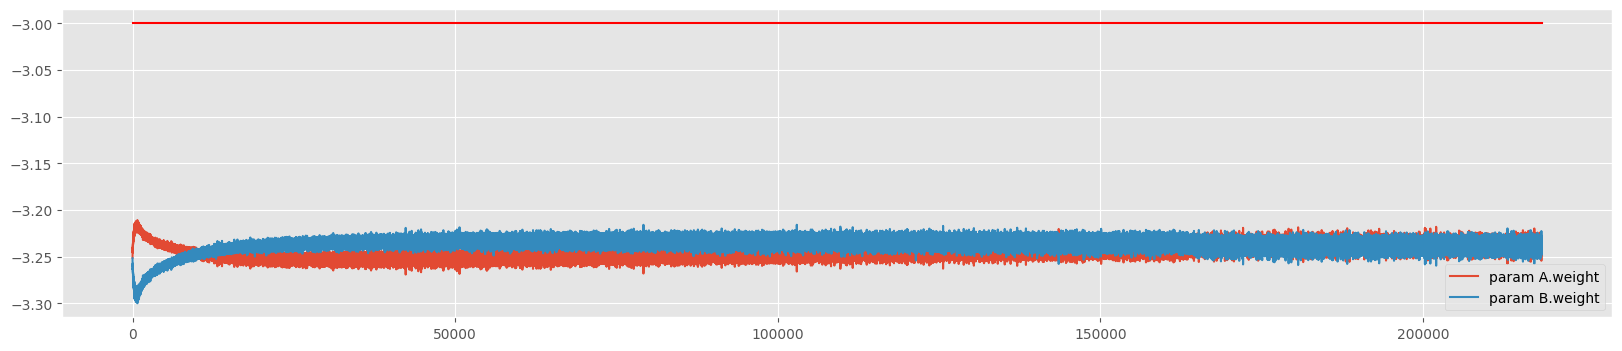

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
legends = []
for i, (name, p) in enumerate(model.named_parameters()):
    plt.plot([ratios[j][i] for j in range(len(ratios))])
    legends.append('param {}'.format(name))
plt.plot([0, len(ratios)], [-3, -3], 'r')
plt.legend(legends)

How do you make sure the learing rate is good? Look at the above plots and suppose we have $log(LR * ratio) = -5$. Then $LR * ratio = 10^{-5}$. Assuming the ratio does not vary much, this probably means we need to increase the learing rate $LR$. Similarly for a reverse direction.